In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Holy search for Determinism

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value = 7

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
#tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# 6. Keras
tf.keras.utils.set_random_seed(seed_value)
tf.config.experimental.enable_op_determinism()

In [3]:
import tensorflow as tf
from tensorflow import keras

# Tests GPU local

In [4]:
print("GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs: 0


In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
print(tf.version.VERSION)

2.8.0


In [7]:
import sys
sys.version

'3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]'

# TP

In [8]:
# de python, para especificar rutas de archivos y directorios
from pathlib import Path
import math

# lib para trabajar con arrays
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt
import seaborn as sns

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de 
# imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten, Rescaling
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import layers

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

In [9]:
from tensorflow.keras.datasets import fashion_mnist
'''
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
(X_train, Y_train) = train 
(X_test, Y_test) = test
'''
train, test = fashion_mnist.load_data()
X_train, Y_train = train 
X_test, Y_test = test

In [10]:
# CONSTANTES

LABELS = np.unique(Y_train).tolist()
LABELS_TEXT = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
INPUTS = 28*28
OUTPUTS = len(LABELS)

# EDA

El dataset se divide en un set de train con 60.000 ejemplos, y un set de test con otros 10.000. Cada ejemplo consta de una imagen en escala de grises de 28x28 pixeles (784 en total), asociado a una etiqueta de 10 clases.
Cada pixel es representado por un solo valor, indicando el nivel de brillo u obscuridad en él. Estos valores van entre 0 y 255.

### Etiquetas
- 0 - T-shirt/top
- 1 - Trouser
- 2 - Pullover
- 3 - Dress
- 4 - Coat
- 5 - Sandal
- 6 - Shirt
- 7 - Sneaker
- 8 - Bag
- 9 - Ankle boot

Las dimensiones de las imágenes pueden apreciarse al hacer un `.shape` de los datasets:

In [11]:
print('Train:', X_train.shape)
print('Test:', X_test.shape)

Train: (60000, 28, 28)
Test: (10000, 28, 28)


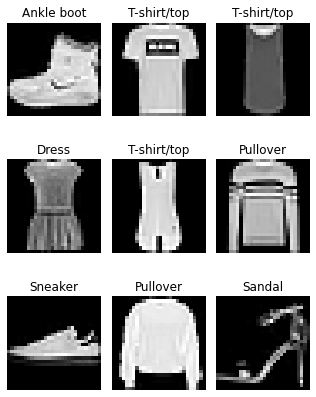

In [12]:
def sample_images(dataset): 
    # specify the number of rows and columns you want to see
    num_row = 3
    num_col = 3

    # get a segment of the dataset
    num = num_row*num_col
    if dataset == train:
        images, labels = X_train[:num], Y_train[:num]
    elif dataset == test:   # Test dataset
        images, labels = X_test[:num], Y_test[:num]
    else:                   # Train with data augmentation dataset
        images, labels = X_train_da[:num], Y_train_da[:num]

    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i], cmap='gray')
        #plt.title(labels[i])
        plt.title(LABELS_TEXT[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

sample_images(train)

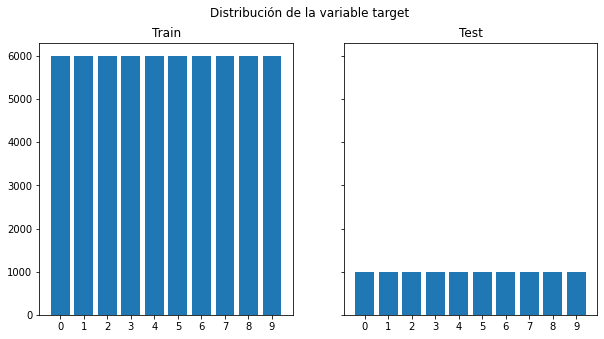

In [13]:
df_ytrain = pd.DataFrame(data=Y_train)
df_ytest = pd.DataFrame(data=Y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
fig.suptitle('Distribución de la variable target')
ax1.bar([0,1,2,3,4,5,6,7,8,9],df_ytrain.value_counts())
ax2.bar([0,1,2,3,4,5,6,7,8,9],df_ytest.value_counts())
ax1.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax2.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax1.title.set_text('Train')
ax2.title.set_text('Test')

La variable a predecir tiene una **distribución uniforme** en todo ambos datasets.

In [14]:
# Escalado de valores a un rango 0-1

#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)


Activation functions
    https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

Loss functions
    https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

Neurons and layers
    https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/
    https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

https://www.hindawi.com/journals/mpe/2013/425740/
https://peerj.com/articles/cs-724/

    The number of hidden neurons should be between the size of the input layer and the size of the output layer.
    The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
    The number of hidden neurons should be less than twice the size of the input layer.


> In modern neural networks, the default recommendation is to use the rectified linear unit or ReLU …

— Page 174, Deep Learning, 2016.

# Funciones

In [15]:
EPOCHS = 50
BATCH_SIZE = 256
VERBOSE = 0

import matplotlib.ticker as ticker

# Fit model
def fit_model(model, x=X_train, y=Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE, compare=True):
    history = model.fit(
        x,
        y,
        epochs = epochs,
        batch_size = batch_size,
        validation_data=(X_test, Y_test),
        verbose=verbose,
    )

    if verbose == 0:
        #print('Trained the model for', epochs, 'epochs')

        final_train_accuracy = model.history.history['accuracy'][-1]
        final_validation_accuracy = model.history.history['val_accuracy'][-1]
        final_train_loss = model.history.history['loss'][-1]
        final_validation_loss = model.history.history['val_loss'][-1]

        if compare:
            initial_train_accuracy = model.history.history['accuracy'][0]
            initial_validation_accuracy = model.history.history['val_accuracy'][0]
            initial_train_loss = model.history.history['loss'][0]
            initial_validation_loss = model.history.history['val_loss'][0]

            middle_value = math.floor(len(model.history.history['accuracy'])/2)

            middle_train_accuracy = model.history.history['accuracy'][middle_value]
            middle_validation_accuracy = model.history.history['val_accuracy'][middle_value]
            middle_train_loss = model.history.history['loss'][middle_value]
            middle_validation_loss = model.history.history['val_loss'][middle_value]

            print('           |           Accuracy           |             Loss             |')
            print('           | Initial    Middle      Final | Initial    Middle      Final |')
            print('     Train |', 
                format(round(initial_train_accuracy, 4), '.4f'),'   ', 
                format(round(middle_train_accuracy, 4), '.4f'),'   ', 
                format(round(final_train_accuracy, 4), '.4f'),'|', 
                format(round(initial_train_loss, 4), '.4f'),'   ', 
                format(round(middle_train_loss, 4), '.4f'),'   ', 
                format(round(final_train_loss, 4), '.4f'),'|')
            print('Validation |', 
                format(round(initial_validation_accuracy, 4), '.4f'),'   ', 
                format(round(middle_validation_accuracy, 4), '.4f'),'   ', 
                format(round(final_validation_accuracy, 4), '.4f'),'|', 
                format(round(initial_validation_loss, 4), '.4f'),'   ', 
                format(round(middle_validation_loss, 4), '.4f'),'   ', 
                format(round(final_validation_loss, 4), '.4f'),'|') 
        else:
            print('           | Accuracy |   Loss   |')
            print('     Train |', 
                format(round(final_train_accuracy, 4), '.4f'),'  |', 
                format(round(final_train_loss, 4), '.4f'),'  |')
            print('Validation |', 
                format(round(final_validation_accuracy, 4), '.4f'),'  |', 
                format(round(final_validation_loss, 4), '.4f'),'  |') 

    return history

# Plot train and validation accuracy and/or loss of up to three models

# Parameter loss works in two ways:
#   - If only one model present, the function plots Accuracy and Loss next to eachother on two subplots
#   - If more than one model present, the function plots Accuracy (if loss=False) or Loss (if loss=True) of all models present
def plot_model(model_1, model_2=None, model_3=None, loss=False, title='', subtitle_1='', subtitle_2='', subtitle_3='', epochs=EPOCHS):
    if loss:
        ylabel = 'Loss'
        train_metric = 'loss'
        validation_metric = 'val_loss'
    else:
        ylabel = 'Accuracy'
        train_metric = 'accuracy'
        validation_metric = 'val_accuracy'

    axes_list = []

    if model_2 is None and model_3 is None:
        if not loss:
            plt.figure(figsize=(7, 5)) 
            plt.title(title)
            plt.plot(model_1.history[train_metric], label='train')
            plt.plot(model_1.history[validation_metric], label='validation')
            if epochs <= 20:
                plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
            else:
                original_ticks_list = np.arange(epochs)
                # Just 3 ticks (min, half, max)
                new_ticks_list = [min(original_ticks_list), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)]
                new_ticks_label_list = [min(original_ticks_list+1), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)+1]
                plt.xticks(new_ticks_list, new_ticks_label_list)
                
            plt.ylabel(ylabel)
            plt.xlabel('Epoch')
            plt.legend(loc='best')
            plt.grid()
            plt.show()
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15.3, 5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax1.plot(model_1.history['accuracy'], label='train')
            ax2.plot(model_1.history['loss'], label='train')
            ax1.plot(model_1.history['val_accuracy'], label='validation')
            ax2.plot(model_1.history['val_loss'], label='validation')

            axes_list = [ax1, ax2]
        
    else:
        if model_3 is None:
            fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15.3, 5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax1.plot(model_1.history[train_metric], label='train')
            ax2.plot(model_2.history[train_metric], label='train')
            ax1.plot(model_1.history[validation_metric], label='validation')
            ax2.plot(model_2.history[validation_metric], label='validation')

            axes_list = [ax1, ax2]

        else:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(24, 5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax3.title.set_text(subtitle_3)
            ax1.plot(model_1.history[train_metric], label='train')
            ax2.plot(model_2.history[train_metric], label='train')
            ax3.plot(model_3.history[train_metric], label='train')
            ax1.plot(model_1.history[validation_metric], label='validation')
            ax2.plot(model_2.history[validation_metric], label='validation')
            ax3.plot(model_3.history[validation_metric], label='validation')

            ax2.tick_params(
            axis='y',
            which='both',   
            left=False
            )  

            axes_list = [ax1, ax2, ax3]

    for ax in axes_list:
        if epochs <= 20:
            ax.set_xticks(np.arange(epochs), np.arange(1, epochs+1))
        else:
            original_ticks_list = np.arange(epochs)
            # Just 3 ticks (min, half, max)
            new_ticks_list = [min(original_ticks_list), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)]
            new_ticks_label_list = [min(original_ticks_list+1), original_ticks_list[math.floor(len(original_ticks_list)/2)], max(original_ticks_list)+1]
            ax.set_xticks(new_ticks_list, new_ticks_label_list)
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend(loc='best')
        ax.grid()

        ax.tick_params(
            axis='y',
            which='both',   
            right=False,
            labelright=False,
            left=True,
            labelleft=True,
        )

# Plot train and validation accuracy of up to three models
def plot_cm(model_1, model_2=None, model_3=None, dataset=train, title='', subtitle_1='', subtitle_2='', subtitle_3=''):
    X_train, Y_train = dataset
    labels = Y_train #Rename just for the sake of understanding

    if model_2 is None and model_3 is None:
        predictions = np.argmax(model_1.predict(X_train), axis=-1)
        
        #print(' - Accuracy:', accuracy_score(labels, predictions))

        fig, ax = plt.subplots(figsize=(7,5))
        ax = sns.heatmap(confusion_matrix(labels, predictions), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT)

        plt.title(title)
        plt.xlabel('Predicted class') 
        plt.ylabel('True class') 
        
    else:
        if model_3 is None:
            predictions_model_1 = np.argmax(model_1.predict(X_train), axis=-1)
            predictions_model_2 = np.argmax(model_2.predict(X_train), axis=-1)

            print(' -', subtitle_1,'Accuracy:', accuracy_score(labels, predictions_model_1))
            print(' -', subtitle_2,'Accuracy:', accuracy_score(labels, predictions_model_2))

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15.3,5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            axes_list = [ax1, ax2]
            g1 = sns.heatmap(confusion_matrix(labels, predictions_model_1), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax1)
            g2 = sns.heatmap(confusion_matrix(labels, predictions_model_2), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax2)

        else:
            predictions_model_1 = np.argmax(model_1.predict(X_train), axis=-1)
            predictions_model_2 = np.argmax(model_2.predict(X_train), axis=-1)
            predictions_model_3 = np.argmax(model_3.predict(X_train), axis=-1)

            print(' -', subtitle_1,'Accuracy:', accuracy_score(labels, predictions_model_1))
            print(' -', subtitle_2,'Accuracy:', accuracy_score(labels, predictions_model_2))
            print(' -', subtitle_3,'Accuracy:', accuracy_score(labels, predictions_model_3))

            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,5))
            fig.suptitle(title)
            ax1.title.set_text(subtitle_1)
            ax2.title.set_text(subtitle_2)
            ax3.title.set_text(subtitle_3)
            axes_list = [ax1, ax2, ax3]
            g1 = sns.heatmap(confusion_matrix(labels, predictions_model_1), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax1)
            g2 = sns.heatmap(confusion_matrix(labels, predictions_model_2), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax2)
            g3 = sns.heatmap(confusion_matrix(labels, predictions_model_3), cmap='Blues', annot=True, fmt='.0f', cbar=True, xticklabels=LABELS_TEXT, yticklabels=LABELS_TEXT, ax=ax3)

        for ax in axes_list:
            ax.set_xlabel('Predicted class')
            ax.set_ylabel('True class')

    plt.tight_layout()
    plt.show()

# MLP Experimentation

Para experimentar con diversos aspectos de redes neuronales MLP vamos a buscar variar no solo su arquitectura -en términos de cantidad de capas ocultas y neuronas- sino también con la cantidad de Epochs, tamaño del Batch Size y learning rate utilizados.

Primero comenzamos planteando modelos muy pequeños, de entre 1 y 3 capas ocultas respectivamente, y con entre 1 y 2 neuronas cada una de ellas. El objetivo de esto es observar el comportamiento de una red neuronal cuando ya no tiene capacidad de seguir aprendiendo. Las observaciones resultantes pueden ayudarnos a comprender de mejor manera el comportamiento de modelos más complejos más adelante.

## One-perceptron layers

Tomando como base el hecho de que queremos mapear nuestros inputs en un espacio de tan solo una dimensión (un array con 10 elementos), en teoría el problema podría ser resuelto por solo una neurona. Por eso mismo las primeras pruebas son modelos con una, dos y tres capas ocultas, cada una con solo una neurona de tipo perceptrón dentro.

Planteamos tres modelos:
1. `mlp_1l_1_relu`: MLP de 1 capa oculta y 1 neurona.
2. `mlp_2l_1_relu`: MLP de 2 capas ocultas y 1 neurona cada una.
3. `mlp_3l_1_relu`: MLP de 3 capas ocultas y 1 neurona cada una.

In [16]:
mlp_1l_1_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_1l_1_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_1l_1_relu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1)                 785       
                                                                 
 dense_1 (Dense)             (None, 10)                20        
                                                                 
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_2l_1_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation='relu'),
    Dense(1, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_1_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_1_relu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 785       
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
 dense_4 (Dense)             (None, 10)                20        
                                                                 
Total params: 807
Trainable params: 807
Non-trainable params: 0
_________________________________________________________________


In [18]:
mlp_3l_1_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation='relu'),
    Dense(1, activation='relu'),
    Dense(1, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_1_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_1_relu.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 785       
                                                                 
 dense_6 (Dense)             (None, 1)                 2         
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
 dense_8 (Dense)             (None, 10)                20        
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [19]:
print('mlp_1l_1_relu')
print()
mlp_1l_1_relu_fit = fit_model(mlp_1l_1_relu, batch_size=256, epochs=200, compare=True)
print()
print('mlp_2l_1_relu')
print()
mlp_2l_1_relu_fit = fit_model(mlp_2l_1_relu, batch_size=256, epochs=200, compare=True)
print()
print('mlp_3l_1_relu')
print()
mlp_3l_1_relu_fit = fit_model(mlp_3l_1_relu, batch_size=256, epochs=200, compare=True)

mlp_1l_1_relu

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.2000     0.4919     0.5401 | 2.0588     1.2091     1.1590 |
Validation | 0.2189     0.4851     0.5426 | 1.9613     1.2274     1.1853 |

mlp_2l_1_relu

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.0977     0.0977     0.0993 | 2.3027     2.3027     2.3027 |
Validation | 0.1000     0.1000     0.1000 | 2.3026     2.3026     2.3026 |

mlp_3l_1_relu

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.0977     0.0977     0.0993 | 2.3027     2.3027     2.3027 |
Validation | 0.1000     0.1000     0.1000 | 2.3026     2.3026     2.3026 |


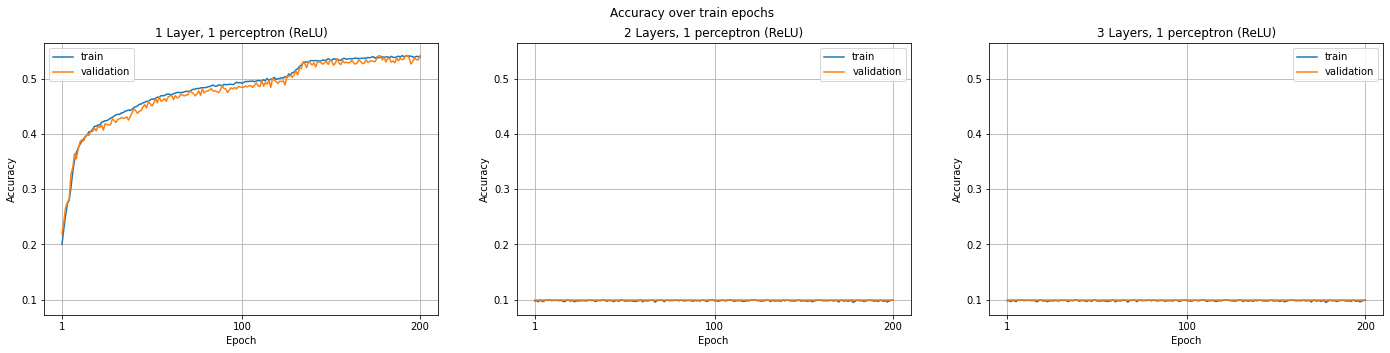

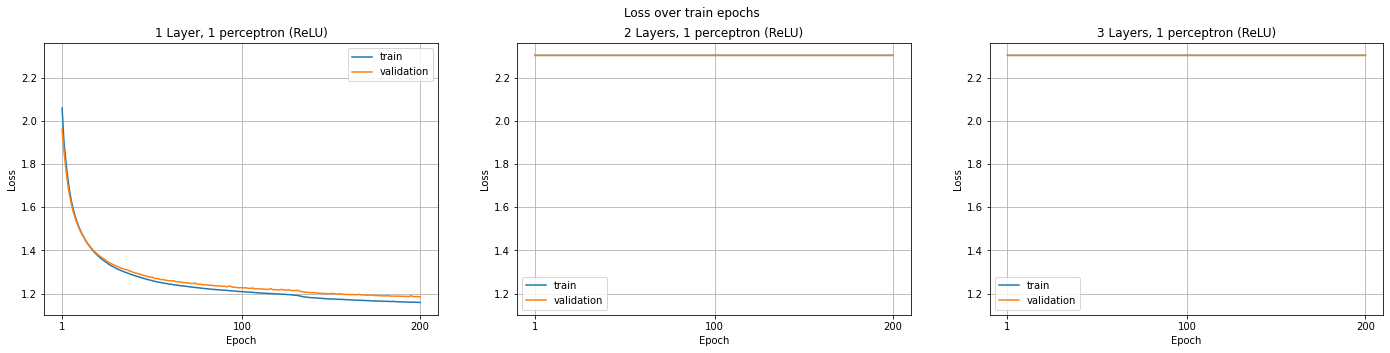

In [20]:
plot_model(model_1=mlp_1l_1_relu_fit, model_2=mlp_2l_1_relu_fit, model_3=mlp_3l_1_relu_fit, epochs=200,
    title='Accuracy over train epochs', subtitle_1='1 Layer, 1 perceptron (ReLU)', subtitle_2='2 Layers, 1 perceptron (ReLU)', subtitle_3='3 Layers, 1 perceptron (ReLU)')
plot_model(model_1=mlp_1l_1_relu_fit, model_2=mlp_2l_1_relu_fit, model_3=mlp_3l_1_relu_fit, epochs=200, loss=True,
    title='Loss over train epochs', subtitle_1='1 Layer, 1 perceptron (ReLU)', subtitle_2='2 Layers, 1 perceptron (ReLU)', subtitle_3='3 Layers, 1 perceptron (ReLU)')

El primer modelo alcanza un Accuracy de 0.55 luego de casi 200 epochs, lo cual uno podría interpretar como interesante considerando que solo utilizamos una capa oculta con una sola neurona. Sin embargo, algo para tener en cuenta es el Loss elevado, que ronda el 1.0.

Mientras tanto, los modelos 2 y 3 quedan estancados con Accuracy en 0.1 y Loss en 2.3. Una de las hipótesis sobre la causa de esto es 'Dying ReLU problem'. Debido a este caso en particular, a continuación planteamos los mismos modelos (2 y 3 capas ocultas con 1 neurona cada una) pero utilizando la función de activación Leaky ReLU, la cual algunas veces permite subsanar dicho problema.

### Leaky ReLU

Planteamos dos modelos:
1. `mlp_2l_1_leakyrelu`: MLP de 2 capas ocultas y 1 neurona cada una, con función de activación LReLU.
2. `mlp_3l_1_leakyrelu`: MLP de 3 capas ocultas y 1 neurona cada una, con función de activación LReLU.

In [16]:
mlp_2l_1_leakyrelu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_1_leakyrelu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_1_leakyrelu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 1)                 785       
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
 dense_2 (Dense)             (None, 10)                20        
                                                                 
Total params: 807
Trainable params: 807
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_3l_1_leakyrelu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(1, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_1_leakyrelu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_1_leakyrelu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 785       
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
 dense_6 (Dense)             (None, 10)                20        
                                                                 
Total params: 809
Trainable params: 809
Non-trainable params: 0
_________________________________________________________________


In [18]:
print('mlp_2l_1_leakyrelu')
print()
mlp_2l_1_leakyrelu_fit = fit_model(mlp_2l_1_leakyrelu, batch_size=256, epochs=200, compare=True)
print()
print('mlp_3l_1_leakyrelu')
print()
mlp_3l_1_leakyrelu_fit = fit_model(mlp_3l_1_leakyrelu, batch_size=256, epochs=200, compare=True)

mlp_2l_1_leakyrelu

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1826     0.5269     0.5313 | 2.0500     1.1002     1.0974 |
Validation | 0.1977     0.5254     0.5404 | 1.9087     1.1192     1.1182 |

mlp_3l_1_leakyrelu

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1670     0.5110     0.5069 | 2.0783     1.2919     1.2879 |
Validation | 0.1920     0.5106     0.5102 | 1.9291     1.3261     1.3236 |


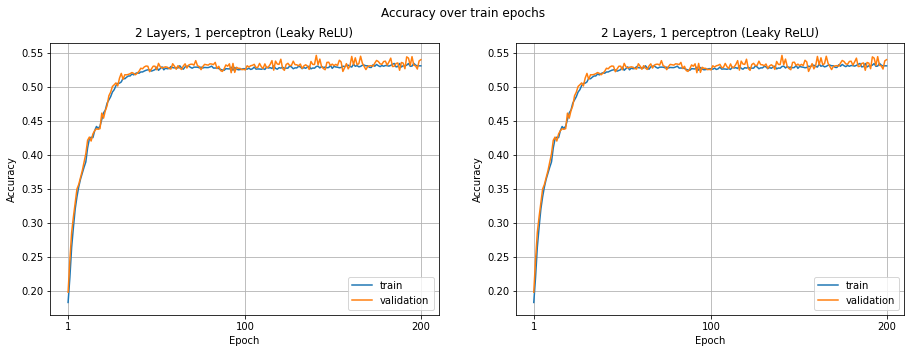

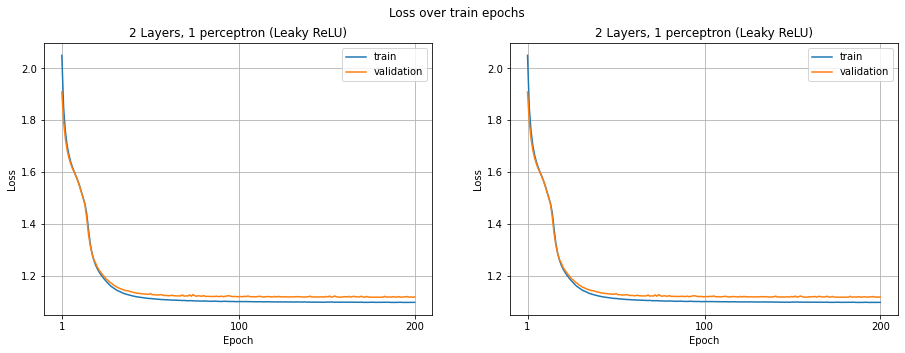

In [19]:
plot_model(model_1=mlp_2l_1_leakyrelu_fit, model_2=mlp_2l_1_leakyrelu_fit, epochs=200,
    title='Accuracy over train epochs', subtitle_1='2 Layers, 1 perceptron (Leaky ReLU)', subtitle_2='2 Layers, 1 perceptron (Leaky ReLU)')
plot_model(model_1=mlp_2l_1_leakyrelu_fit, model_2=mlp_2l_1_leakyrelu_fit, epochs=200, loss=True,
    title='Loss over train epochs', subtitle_1='2 Layers, 1 perceptron (Leaky ReLU)', subtitle_2='2 Layers, 1 perceptron (Leaky ReLU)')

El uso de Leaky ReLU en los modelos 2 y 3 evita el estancamiento visto en las ejecuciones anteriores. Respecto a su rendimiento, estos modelos llegan a un Accuracy similar al modelo 1 anterior (1 layer, 1 perceptron (ReLU)) en muchas menos epochs, y con un Loss un tanto menor, aunque todavía elevado en términos generales.

## Two-perceptron Layers

Planteamos tres modelos con solo dos neuronas en cada una de sus capas ocultas:
1. `mlp_1l_2_relu`: MLP de 1 capa oculta y 2 neuronas.
1. `mlp_2l_2_relu`: MLP de 2 capas ocultas y 2 neuronas cada una.
1. `mlp_3l_2_relu`: MLP de 3 capas ocultas y 2 neuronas cada una.

In [17]:
mlp_1l_2_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_1l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_1l_2_relu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,600
Trainable params: 1,600
Non-trainable params: 0
_________________________________________________________________


In [18]:
mlp_2l_2_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_2_relu.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 1570      
                                                                 
 dense_3 (Dense)             (None, 2)                 6         
                                                                 
 dense_4 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
_________________________________________________________________


In [19]:
mlp_3l_2_relu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_3l_2_relu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_3l_2_relu.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 1570      
                                                                 
 dense_6 (Dense)             (None, 2)                 6         
                                                                 
 dense_7 (Dense)             (None, 2)                 6         
                                                                 
 dense_8 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [20]:
print('mlp_1l_2_relu')
print()
mlp_1l_2_relu_fit = fit_model(mlp_1l_2_relu, batch_size=256, epochs=200, compare=True)
print()
print('mlp_2l_2_relu')
print()
mlp_2l_2_relu_fit = fit_model(mlp_2l_2_relu, batch_size=256, epochs=200, compare=True)
print()
print('mlp_3l_2_relu')
print()
mlp_3l_2_relu_fit = fit_model(mlp_3l_2_relu, batch_size=256, epochs=200, compare=True)

mlp_1l_2_relu

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.2874     0.7260     0.7368 | 1.8400     0.7790     0.7577 |
Validation | 0.3863     0.7179     0.7245 | 1.5947     0.8179     0.8030 |

mlp_2l_2_relu

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.0977     0.0977     0.0993 | 2.3027     2.3027     2.3027 |
Validation | 0.1000     0.1000     0.1000 | 2.3026     2.3026     2.3026 |

mlp_3l_2_relu

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1906     0.6930     0.7130 | 2.0695     0.8405     0.8129 |
Validation | 0.1970     0.6842     0.7066 | 1.9872     0.8715     0.8583 |


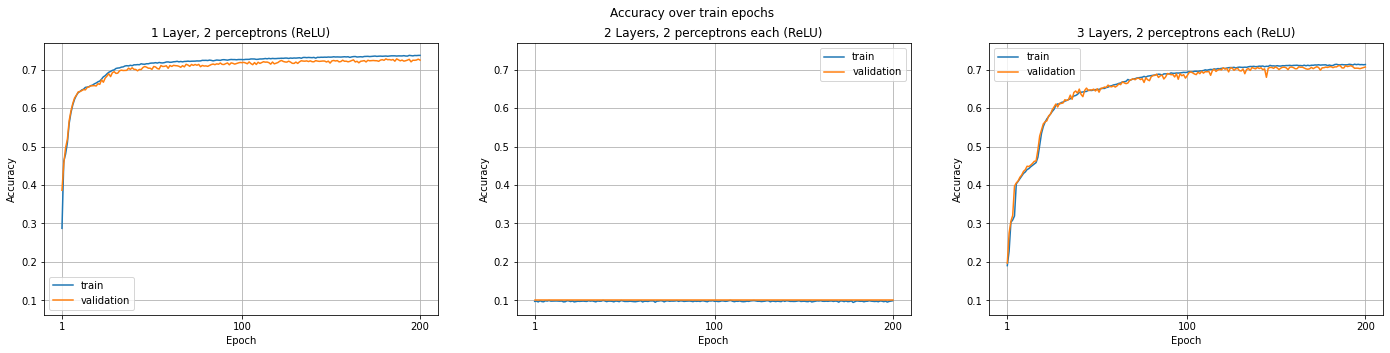

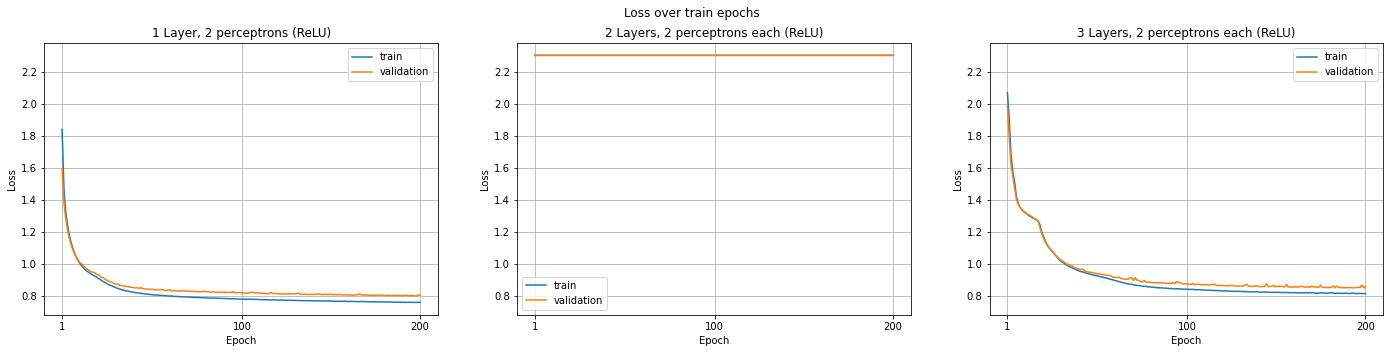

In [21]:
plot_model(model_1=mlp_1l_2_relu_fit, model_2=mlp_2l_2_relu_fit, model_3=mlp_3l_2_relu_fit, epochs=200,
    title='Accuracy over train epochs', subtitle_1='1 Layer, 2 perceptrons (ReLU)', subtitle_2='2 Layers, 2 perceptrons each (ReLU)', subtitle_3='3 Layers, 2 perceptrons each (ReLU)')
plot_model(model_1=mlp_1l_2_relu_fit, model_2=mlp_2l_2_relu_fit, model_3=mlp_3l_2_relu_fit, epochs=200, loss=True,
    title='Loss over train epochs', subtitle_1='1 Layer, 2 perceptrons (ReLU)', subtitle_2='2 Layers, 2 perceptrons each (ReLU)', subtitle_3='3 Layers, 2 perceptrons each (ReLU)')

Podemos observar que en primer y tercer modelo obtienen resultados similares, solo que el primero tiene meejor Accuracy y peor Loss que el otro. El Accuracy de ambos tiene una asíntota en 0.70-0.75. Cabe destacar que el tercero tarda muchos más epochs en llegar al mismo nivel.

Por su parte, tanto el Accuracy como el Loss del segundo modelo quedan estancados en 0.1 y 2.3 respectivamente por la totalidad del entrenamiento. De nuevo, una de las hipótesis sobre la causa de esto es 'Dying ReLU problem' mencionado antes. Debido a esto, a continuación planteamos el mismo modelo (2 capas ocultas con 2 neuronas cada una) utilizando la función de activación Leaky ReLU.

### Leaky ReLU

Planteamos un modelos:
1. `mlp_2l_2_leakyrelu`: MLP de 2 capas ocultas y 2 neuronas cada una, con función de activación LReLU.

In [16]:
mlp_2l_2_leakyrelu = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(2, activation=tf.keras.layers.LeakyReLU(alpha=0.3)),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_2l_2_leakyrelu.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_2l_2_leakyrelu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 2)                 1570      
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
Total params: 1,606
Trainable params: 1,606
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_2l_2_leakyrelu_fit = fit_model(mlp_2l_2_leakyrelu, batch_size=256, epochs=200, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.2598     0.7363     0.7536 | 1.9538     0.7384     0.6822 |
Validation | 0.3331     0.7222     0.7384 | 1.7569     0.7836     0.7517 |


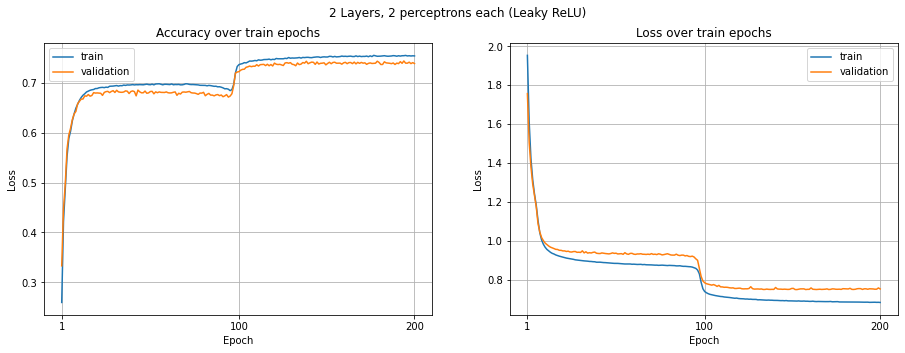

In [18]:
plot_model(model_1=mlp_2l_2_leakyrelu_fit, epochs=200, loss=True,
    title='2 Layers, 2 perceptrons each (Leaky ReLU)', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

El rendimiento de este modelo que utiliza Leaky ReLU como función de activación arroja valores finales similares a la tanda anterior que utilizaba ReLU, pero, al igual que el último de la misma, requiere de muchos epochs de entrenamiento adicionales para llegar al mismo punto del primer ejemplo. Algo a destacar es un Loss un tanto menor que todos los ejemplos anteriores.

Sea cual sea el caso, llega un punto donde ninguno puede seguir aprendiendo (cerca de Accuracy = 0.75), lo cual demanda que planteemos redes más profundas. Esto les dará la posibilidad de reconocer detalles o aspectos más abstractos. La cantidad de neuronas también será variada ligeramente, buscando mejor Accuracy, menor Loss y tratando de evitar el overfitting.

## Batch Size

Planteamos un modelo MLP de prueba y lo entrenamos con tres `batch_size` diferentes (64, 256 y 1024) para así analizar el comportamiento del mismo.

In [16]:
mlp_batch_test = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(5, activation='relu'),
    Dense(5, activation='relu'),
    Dense(2, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_batch_test.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_batch_test.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 5)                 3925      
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 2)                 12        
                                                                 
 dense_3 (Dense)             (None, 10)                30        
                                                                 
Total params: 3,997
Trainable params: 3,997
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_batch_test_b64 = fit_model(mlp_batch_test, batch_size=64, epochs=200, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.3968     0.8009     0.8059 | 1.5523     0.5703     0.5514 |
Validation | 0.5639     0.7724     0.7788 | 1.2043     0.7159     0.7528 |


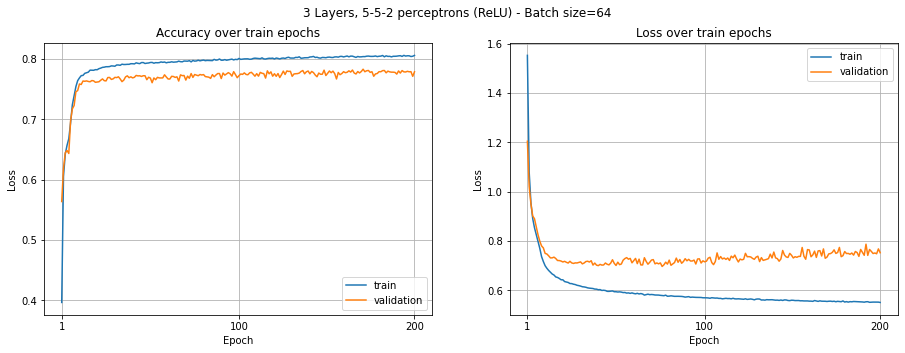

In [19]:
plot_model(mlp_batch_test_b64, epochs=200, loss=True,
    title='3 Layers, 5-5-2 perceptrons (ReLU) - Batch size=64', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

El gráfico de Loss indica cómo en las cercanías del Epoch nro. 25 los errores de Validation comienzan a ir en alza, mientras que los errores de Train continúan a la baja. Esto indica un overfitting, por lo que una de las alternativas sería cortar el entrenamiento en ese punto.

In [17]:
mlp_batch_test_b256 = fit_model(mlp_batch_test, batch_size=256, epochs=200, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1664     0.7506     0.7745 | 2.0683     0.7063     0.6351 |
Validation | 0.2029     0.7399     0.7561 | 1.8864     0.7786     0.7383 |


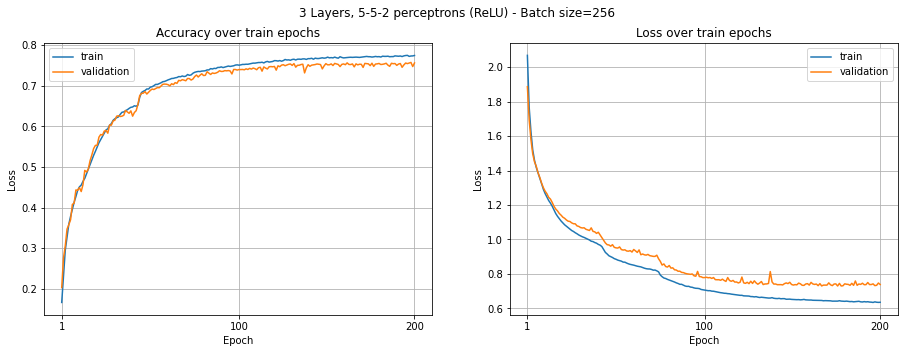

In [19]:
plot_model(mlp_batch_test_b256, epochs=200, loss=True,
    title='3 Layers, 5-5-2 perceptrons (ReLU) - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_batch_test_b1024 = fit_model(mlp_batch_test, batch_size=1024, epochs=200, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1432     0.7499     0.7580 | 2.1976     0.7250     0.6896 |
Validation | 0.1693     0.7378     0.7402 | 2.1373     0.8116     0.7973 |


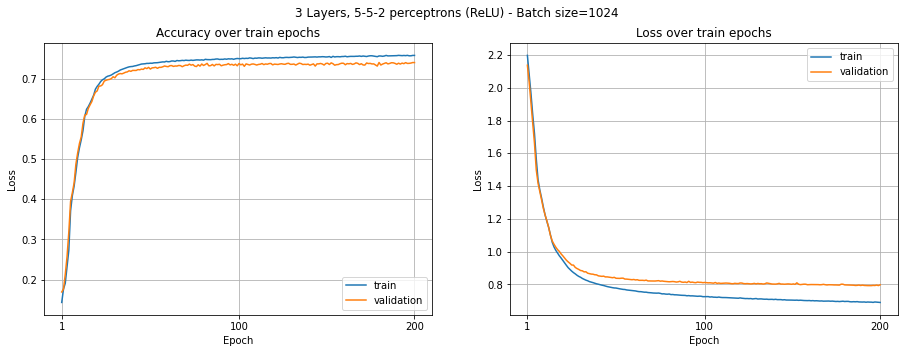

In [19]:
plot_model(mlp_batch_test_b1024, epochs=200, loss=True,
    title='3 Layers, 5-5-2 perceptrons (ReLU) - Batch size=1024', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

Comparación del tiempo de entrenamiento requerido por el mismo modelo entrenado con diferentes `batch_size`:

| batch_size | Tiempo (s)  |
| ---------- | ----------- |
| 64         | 208         |
| 256        | 81          |
| 1024       | 61          |

- Un mayor `batch_size` conlleva un entrenamiento más rápido, ya que los pesos internos del modelo se actualizan con menor frecuencia. 
- El Accuracy disminuye a medida que aumenta el `batch_size`; consecuencia directa de que los pesos se actualicen menos seguido.
- El Loss de Validation continúa aumentando respecto al de Train a medida que pasan los `epochs`. Esto es otro indicativo de overfitting.

## Cantidad de neuronas

Planteamos tres modelos MLP con tres capas ocultas cada uno, pero diferente cantidad de neuronas en cada una de ellas. Estructura de los mismos:
1. `mlp_perceptron_test_1`: 100-100-50
2. `mlp_perceptron_test_2`: 50-50-25
3. `mlp_perceptron_test_3`: 10-10-5

In [16]:
mlp_perceptron_test_1 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(100, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_perceptron_test_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_perceptron_test_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 10)                510       
                                                                 
Total params: 94,160
Trainable params: 94,160
Non-trainable params: 0
_________________________________________________________________


In [16]:
mlp_perceptron_test_2 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(25, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_perceptron_test_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_perceptron_test_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 10)                260       
                                                                 
Total params: 43,335
Trainable params: 43,335
Non-trainable params: 0
_________________________________________________________________


In [16]:
mlp_perceptron_test_3 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_perceptron_test_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_perceptron_test_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 10)                60        
                                                                 
Total params: 8,075
Trainable params: 8,075
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_perceptron_test_1_fit = fit_model(mlp_perceptron_test_1, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.7851     0.9316     0.9623 | 0.6355     0.1797     0.1018 |
Validation | 0.8303     0.8884     0.8818 | 0.4773     0.3475     0.4850 |


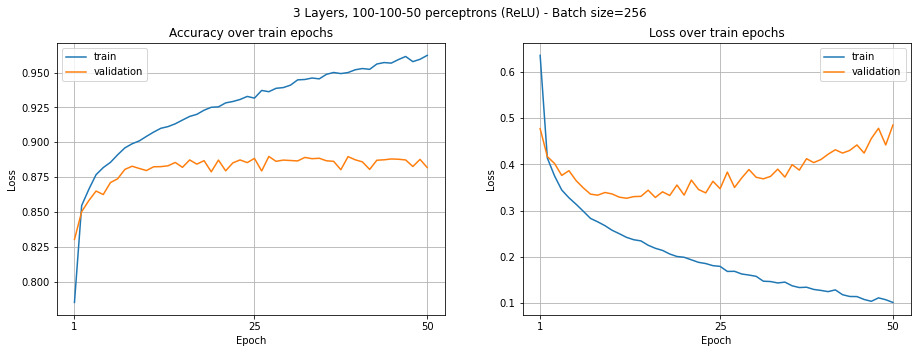

In [18]:
plot_model(mlp_perceptron_test_1_fit, epochs=50, loss=True,
    title='3 Layers, 100-100-50 perceptrons (ReLU) - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_perceptron_test_2_fit = fit_model(mlp_perceptron_test_2, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.7586     0.9149     0.9373 | 0.7070     0.2286     0.1678 |
Validation | 0.8209     0.8750     0.8776 | 0.5093     0.3698     0.4083 |


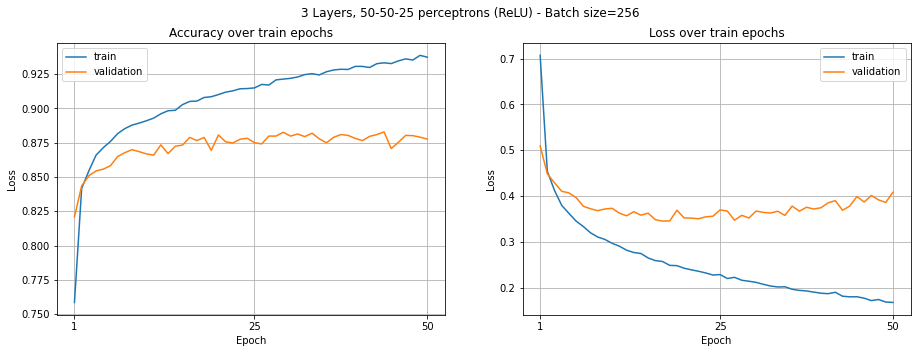

In [18]:
plot_model(mlp_perceptron_test_2_fit, epochs=50, loss=True,
    title='3 Layers, 50-50-25 perceptrons (ReLU) - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_perceptron_test_3_b256 = fit_model(mlp_perceptron_test_3, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.4975     0.8649     0.8753 | 1.5623     0.3873     0.3535 |
Validation | 0.6910     0.8476     0.8481 | 1.0185     0.4421     0.4362 |


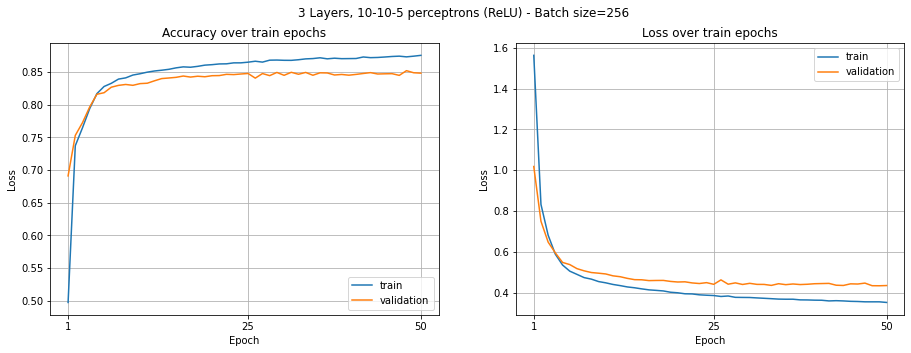

In [18]:
plot_model(mlp_perceptron_test_3_b256, epochs=50, loss=True,
    title='3 Layers, 10-10-5 perceptrons (ReLU) - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

A partir de los gráficos observados podemos concluir que, a mayor cantidad de neuronas, las redes alcanzan un Accuracy mayor en menor cantidad de Epochs, y también comienzan con un Loss menor desde el principio. 

Por otro lado, las redes 1 y 2 (100-100-50 y 50-50-25) overfitean en el Epoch 15 y 20 respectivamente, ya que la cantidad de neuronas en sus capas les otorgan una cantidad de procesamiento superior, que terminan utilizando para aprender detalles muy particulares del set Train. Esto conlleva a que el Loss de Validation comience a aumentar a partir de los puntos antes mencioandos.

Ante esta situación tenemos varias alternativas:
1. Añadir capas de dropout.
2. Reducir la cantidad de capas y/o neuronas.
3. Añadir más datos.

Procedemos a testear la primer situación, utilizando capas de Dropout entre las capas ocultas del modelo 1.

### Test con Dropout

In [16]:
mlp_perceptron_test_1_d01 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dropout(0.1),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(100, activation='relu'),
    Dropout(0.1),
    Dense(50, activation='relu'),
    Dropout(0.1),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_perceptron_test_1_d01.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_perceptron_test_1_d01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5

In [16]:
mlp_perceptron_test_1_d02 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_perceptron_test_1_d02.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_perceptron_test_1_d02.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 50)                5

In [17]:
mlp_perceptron_test_1_d01_b256 = fit_model(mlp_perceptron_test_1_d01, batch_size=256, epochs=100, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.7285     0.9127     0.9246 | 0.7729     0.2318     0.2001 |
Validation | 0.8312     0.8900     0.8979 | 0.4697     0.3122     0.3073 |


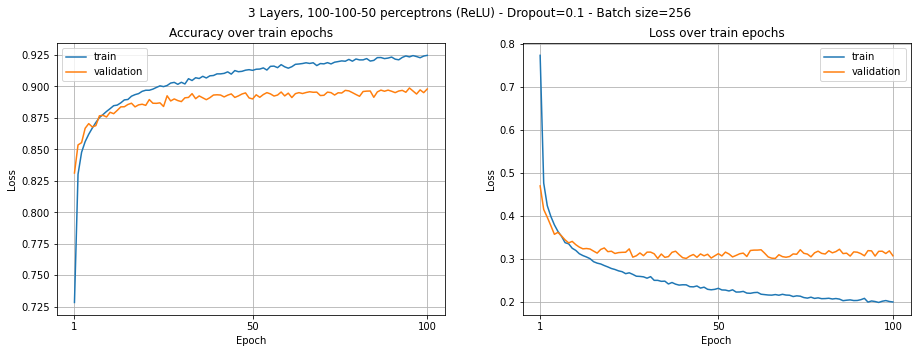

In [18]:
plot_model(mlp_perceptron_test_1_d01_b256, epochs=100, loss=True,
    title='3 Layers, 100-100-50 perceptrons (ReLU) - Dropout=0.1 - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_perceptron_test_1_d02_b256 = fit_model(mlp_perceptron_test_1_d02, batch_size=256, epochs=100, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.6772     0.8865     0.8963 | 0.9054     0.3057     0.2783 |
Validation | 0.8138     0.8846     0.8921 | 0.5019     0.3123     0.2998 |


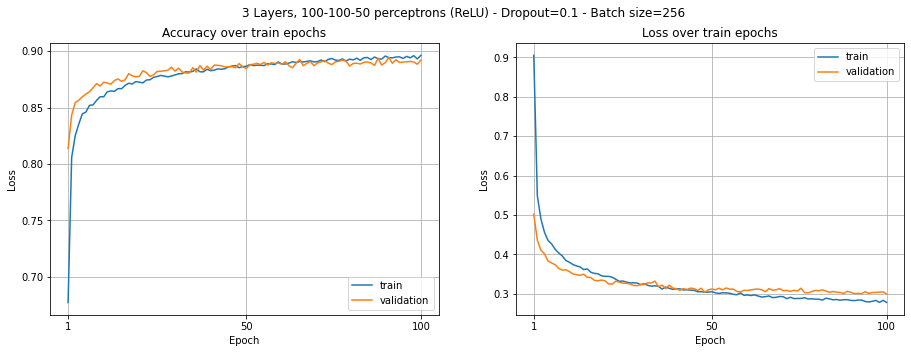

In [18]:
plot_model(mlp_perceptron_test_1_d02_b256, epochs=100, loss=True,
    title='3 Layers, 100-100-50 perceptrons (ReLU) - Dropout=0.1 - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_perceptron_test_1_d02_b256 = fit_model(mlp_perceptron_test_1_d02, batch_size=256, epochs=150, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.6772     0.8921     0.9007 | 0.9054     0.2884     0.2696 |
Validation | 0.8138     0.8904     0.8902 | 0.5019     0.3145     0.2988 |


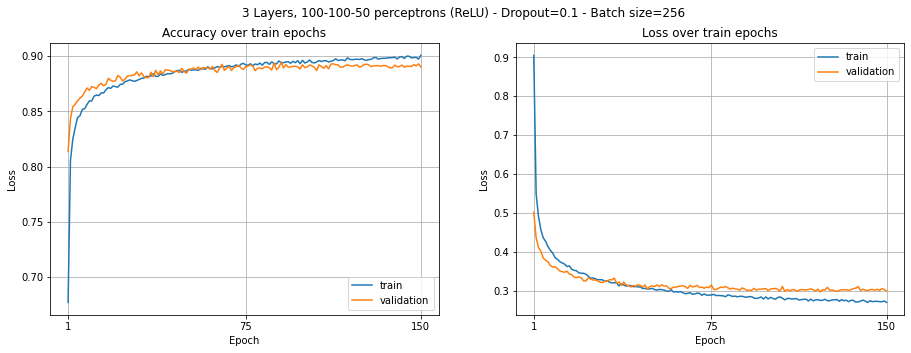

In [18]:
plot_model(mlp_perceptron_test_1_d02_b256, epochs=150, loss=True,
    title='3 Layers, 100-100-50 perceptrons (ReLU) - Dropout=0.1 - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

La adición de las capas de Dropout logró controlar el overfitting que veíamos en los casos anteriores. De todas maneras, la configuración de la tasa de Dropout es de gran importancia junto a la cantidad de Epochs que se entrena al modelo, ya que Dropout no aplica para Validation, por lo que las métricas en un primer punto muestran un Accuracy de Validation mayor al de Train, y viceversa en el Loss.

En el primer caso (Dropout(0.1)) las métricas convergen en las cercanías del Epoch 6, y el Loss de Validation llega a una asíntota en 0.3, por lo que sería prudente cortar su entrenamiento en el Epoch 40. Nientras que en el segundo caso (Dropout(0.2)) las métricas convergen múltiples veces a partir del Epoch 25. Hacia el final del entrenamiento definido el Loss de Validation rompe el piso de 0.3, pero parece que también se mantiene con una asíntota en Loss = 0.3 y Accuracy = 0.89, por lo que sería conveniente cortar su entrenamiento en el Epoch 75.

## Profundidad

Si bien es teóricamente posible representar cualquier función con una red neuronal de solo una capa oculta, determinar la cantidad de neuronas que debe tener esa capa es dificil. Por lo tanto, añadir más capas permite, entre otras cosas, que las primeras capas aprendan ciertas abstracciones que luego se conviertan en inputs de la siguiente. En teoría una sola capa debería arrojar resultados similares, pero requeriría de una cantidad de neuronas mucho mayor.

Para esta prueba planteamos dos modelos:
1. `mlp_depth_test_1`: MLP de 3 capas ocultas con una estructura 10-10-5.
2. `mlp_depth_test_2`: MLP de 1 capa oculta con 500 neuronas.

In [16]:
mlp_depth_test_1 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_depth_test_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_depth_test_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 10)                60        
                                                                 
Total params: 8,075
Trainable params: 8,075
Non-trainable params: 0
_________________________________________________________________


In [16]:
mlp_depth_test_2 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(500, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_depth_test_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_depth_test_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 10)                5010      
                                                                 
Total params: 397,510
Trainable params: 397,510
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_depth_test_1_fit = fit_model(mlp_depth_test_1, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.4975     0.8649     0.8753 | 1.5623     0.3873     0.3535 |
Validation | 0.6910     0.8476     0.8481 | 1.0185     0.4421     0.4362 |


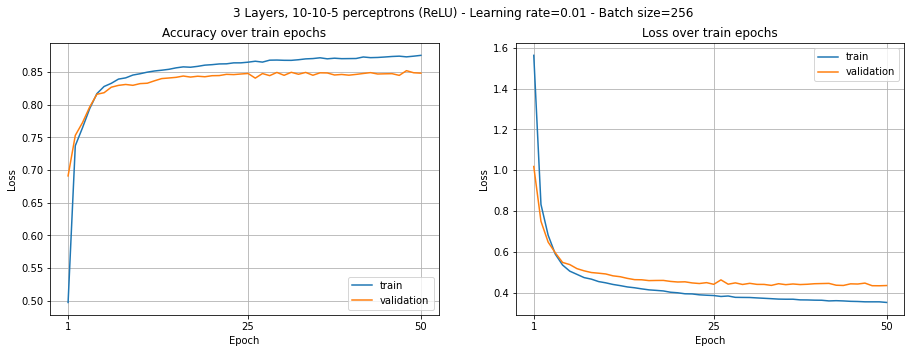

In [18]:
plot_model(mlp_depth_test_1_fit, epochs=50, loss=True,
    title='3 Layers, 10-10-5 perceptrons (ReLU) - Learning rate=0.01 - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [18]:
mlp_depth_test_2_fit = fit_model(mlp_depth_test_2, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.8153     0.9483     0.9753 | 0.5333     0.1416     0.0685 |
Validation | 0.8438     0.8938     0.8955 | 0.4414     0.3331     0.4122 |


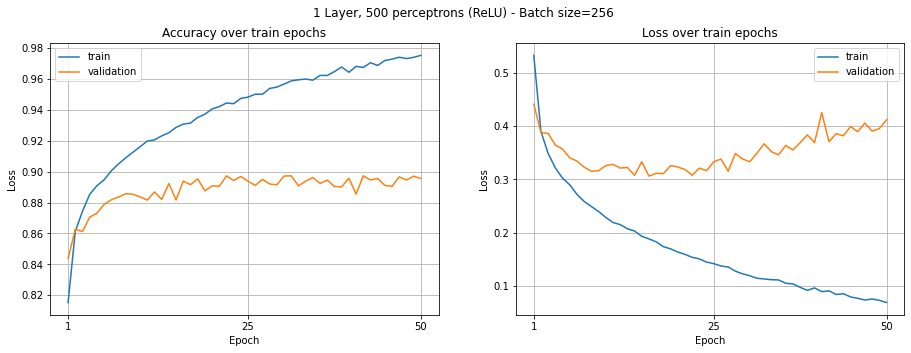

In [20]:
plot_model(mlp_depth_test_2_fit, epochs=50, loss=True,
    title='1 Layer, 500 perceptrons (ReLU) - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

En el segundo modelo multiplicamos x10 cantidad de neuronas del primero y obtuvimos un Accuracy de Validation un tanto más alto (0.89 contra 0.84), junto a un Loss de Validation un tanto menor (0.31 contra 0.43).
Sin embargo, las métricas del segundo modelo muestran un claro overfitting a partir del Epoch 12, por lo que su entrenamiento debería terminar en ese punto. Además, la segunda red tardó casi 140 segundos en entrenarse por 50 epochs, comparado a los tan solo 23 segundos de la primera.

Debe tenerse en cuenta que no es habitual el uso de redes de profundidad 1 con muchas neuronas, y generalmente es preferible utilizar más capas antes que más neuronas para evitar los problemas mencionados antes.

## Learning Rate

Para evaluar cómo afecta un diferente `learning_rate` al mismo modelo, planteamos una red MLP con tres capas ocultas (dispuestas de manera 10-10-5). Se crean tres modelos iguales, variando solo el `learning_rate` en factores de 10:
1. `mlp_lr_test_1`: `learning_rate`=0.001 (Default)
2. `mlp_lr_test_2`: `learning_rate`=0.0001
3. `mlp_lr_test_3`: `learning_rate`=0.01

In [16]:
mlp_lr_test_1 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_lr_test_1.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001, #Default
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_lr_test_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 10)                60        
                                                                 
Total params: 8,075
Trainable params: 8,075
Non-trainable params: 0
_________________________________________________________________


In [16]:
mlp_lr_test_2 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_lr_test_2.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_lr_test_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 10)                60        
                                                                 
Total params: 8,075
Trainable params: 8,075
Non-trainable params: 0
_________________________________________________________________


In [16]:
mlp_lr_test_3 = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(5, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

mlp_lr_test_3.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_lr_test_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 10)                60        
                                                                 
Total params: 8,075
Trainable params: 8,075
Non-trainable params: 0
_________________________________________________________________


In [17]:
mlp_lr_test_1_fit = fit_model(mlp_lr_test_1, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.4975     0.8649     0.8753 | 1.5623     0.3873     0.3535 |
Validation | 0.6910     0.8476     0.8481 | 1.0185     0.4421     0.4362 |


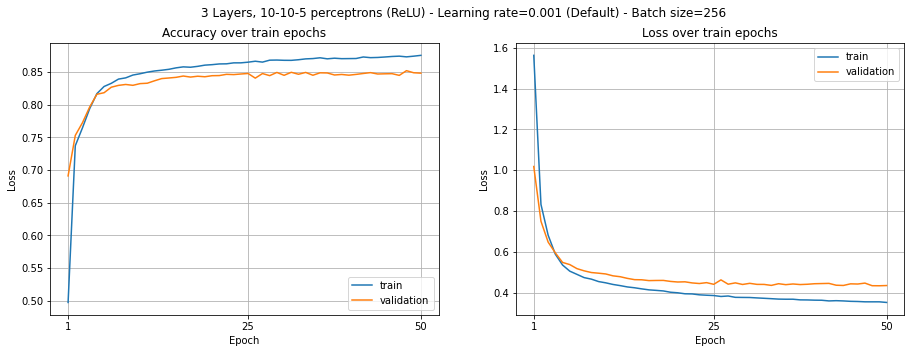

In [18]:
plot_model(mlp_lr_test_1_fit, epochs=50, loss=True,
    title='3 Layers, 10-10-5 perceptrons (ReLU) - Learning rate=0.001 (Default) - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_lr_test_2_fit = fit_model(mlp_lr_test_2, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.2584     0.7823     0.8321 | 2.1977     0.6584     0.5097 |
Validation | 0.3249     0.7756     0.8200 | 2.0871     0.6758     0.5425 |


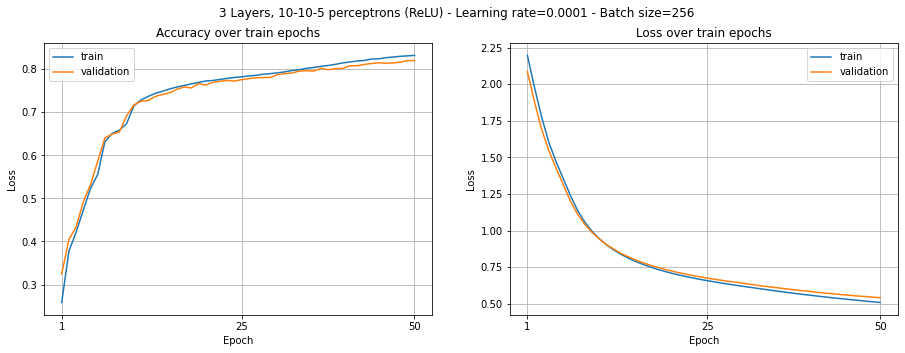

In [18]:
plot_model(mlp_lr_test_2_fit, epochs=50, loss=True,
    title='3 Layers, 10-10-5 perceptrons (ReLU) - Learning rate=0.0001 - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_lr_test_3_fit = fit_model(mlp_lr_test_3, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.6269     0.8475     0.8510 | 0.9626     0.4292     0.4191 |
Validation | 0.7551     0.8298     0.8269 | 0.6432     0.4985     0.5090 |


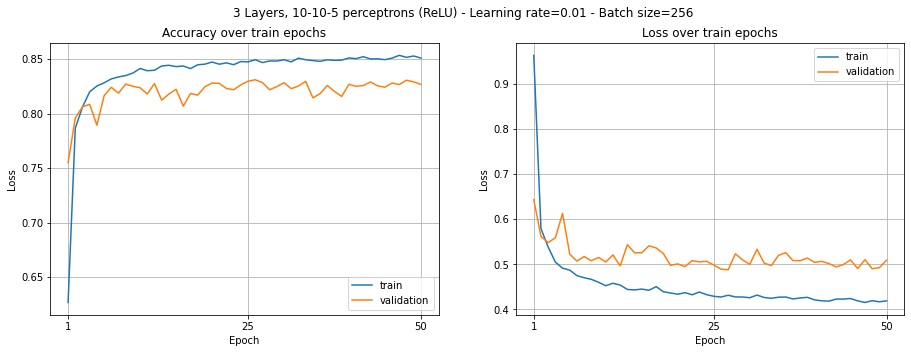

In [20]:
plot_model(mlp_lr_test_3_fit, epochs=50, loss=True,
    title='3 Layers, 10-10-5 perceptrons (ReLU) - Learning rate=0.01 - Batch size=256', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

Conclusiones acerca de la variación en el `learning rate`:
- Un `learning_rate` más bajo implica un gráfico más 'suave' y que requiere mayor cantidad de Epochs para arribar al mismo resultado que la red con `learning_rate` por default.
- Un `learning_rate` más acarrea métricas con mayor cantidad de inestabilidad, pero requiere de menos Epochs para llegar al mismo resultado que la red con `learning_rate` por default.

La elección de un `learning_rate` adecuado es muy importante, ya que uno demasiado grande puede hacer que el modelo converja demasiado rápido en una solución que no es óptima, mientras que uno muy pequeño puede causar que el modelo se quede estancado.

## Pruebas
Tomando en cuenta todas las observaciones y conclusiones anteriores planteamos un nuevo modelo con mayor cantidad de capas.

## Grid Search MLP

Para definir los hiperparámetros de nuestra red MLP final utilizamos un GridSearchCV.

Los parámetros a evaluar son:
1. Configuración de las capas ocultas: Entre dos opciones (10x20 o 4x50)
2. `batch_size`: Entre 256 y 512
3. `alpha`: Entre 1e-6, 1e-4 (default) y 1e-2

Otros parámetros, como las funciones de activación, Epochs máximas y el optimizador ya los decidimos en base a pruebas anteriores.

In [ ]:
feature_vector_length = 784
num_classes = 10

X_trainR = X_train.reshape(X_train.shape[0], feature_vector_length)
X_testR = X_test.reshape(X_test.shape[0], feature_vector_length)

import itertools
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix 

# defining parameter range 
param_grid = {
    'hidden_layer_sizes': [(20,20,20,20,20,20,20,20,20,20),(50,50,50,50)],
    'batch_size': [256, 512],
    'alpha': [0.000001, 0.0001, 0.01],
    
    'activation': ['relu'],
    'max_iter': [50],
    'solver': ['adam'],
}  

mlp_gridsearchcv_model = GridSearchCV(MLPClassifier(), param_grid=param_grid, n_jobs=1, verbose=3, cv=3)

# fitting the model for grid search 
mlp_gridsearchcv_model.fit(X_trainR, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END activation=relu, alpha=1e-06, batch_size=256, hidden_layer_sizes=(20, 20, 20, 20, 20, 20, 20, 20, 20, 20), max_iter=50, solver=adam;, score=0.866 total time=  36.4s
[CV 2/3] END activation=relu, alpha=1e-06, batch_size=256, hidden_layer_sizes=(20, 20, 20, 20, 20, 20, 20, 20, 20, 20), max_iter=50, solver=adam;, score=0.872 total time=  36.4s
[CV 3/3] END activation=relu, alpha=1e-06, batch_size=256, hidden_layer_sizes=(20, 20, 20, 20, 20, 20, 20, 20, 20, 20), max_iter=50, solver=adam;, score=0.868 total time=  35.4s
[CV 1/3] END activation=relu, alpha=1e-06, batch_size=256, hidden_layer_sizes=(50, 50, 50, 50), max_iter=50, solver=adam;, score=0.874 total time=  30.5s
[CV 2/3] END activation=relu, alpha=1e-06, batch_size=256, hidden_layer_sizes=(50, 50, 50, 50), max_iter=50, solver=adam;, score=0.883 total time=  30.3s
[CV 3/3] END activation=relu, alpha=1e-06, batch_size=256, hidden_layer_sizes=(50, 50, 50, 50), m

GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=1,
             param_grid={'activation': ['relu'], 'alpha': [1e-06, 0.0001, 0.01],
                         'batch_size': [256, 512],
                         'hidden_layer_sizes': [(20, 20, 20, 20, 20, 20, 20, 20,
                                                 20, 20),
                                                (50, 50, 50, 50)],
                         'max_iter': [50], 'solver': ['adam']},
             verbose=3)

In [ ]:
print('Mejores parámetros encontrados por GridSearchCV:')
print('\t', mlp_gridsearchcv_model.best_params_) 
print()
grid_predictions = mlp_gridsearchcv_model.predict(X_testR) 

print(classification_report(Y_test, grid_predictions)) 

Mejores parámetros encontrados por GridSearchCV:
	 {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 256, 'hidden_layer_sizes': (50, 50, 50, 50), 'max_iter': 50, 'solver': 'adam'}

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.97      0.98      0.98      1000
           2       0.83      0.78      0.80      1000
           3       0.85      0.91      0.88      1000
           4       0.79      0.84      0.81      1000
           5       0.97      0.95      0.96      1000
           6       0.73      0.69      0.71      1000
           7       0.94      0.96      0.95      1000
           8       0.98      0.95      0.96      1000
           9       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



A continuación armamos el modelo resultante de GridSearchCV y lo ejecutamos con los parámetros indicados:

In [16]:
mlp_final = Sequential([
    Flatten(input_shape=(28,28,1)),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_final.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

mlp_final.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 50)                2550      
                                                                 
 dense_4 (Dense)             (None, 10)                510       
                                                                 
Total params: 47,410
Trainable params: 47,410
Non-traina

In [19]:
mlp_final_fit = fit_model(mlp_final, batch_size=256, epochs=100, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.7595     0.9476     0.9696 | 0.6932     0.1418     0.0807 |
Validation | 0.8354     0.8762     0.8768 | 0.4718     0.4358     0.6559 |


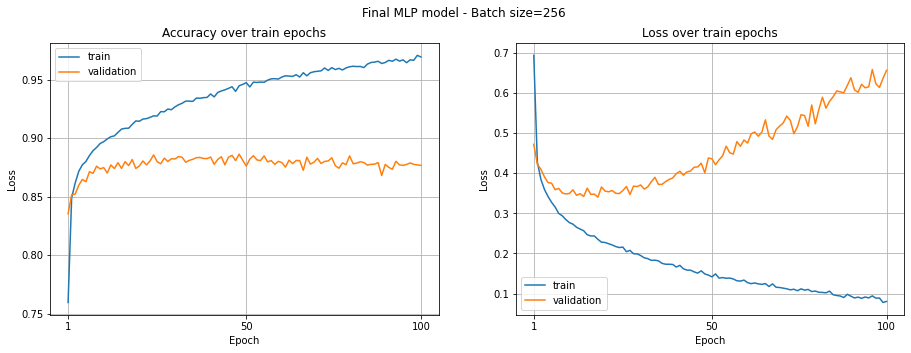

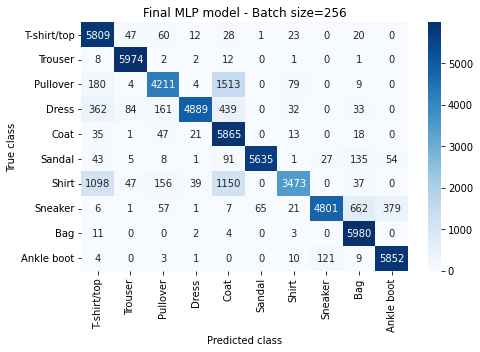

In [24]:
plot_model(mlp_final_fit, epochs=100, loss=True,
    title="Final MLP model - Batch size=256", subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

plot_cm(mlp_final, title="Final MLP model - Batch size=256")

Debido al claro overfitting que ocurre en el Epoch 13, procedemos a entrenar el modelo de nuevo pero limitando la cantidad máxima de epochs a ese punto:

In [17]:
mlp_final_fit_e13 = fit_model(mlp_final, batch_size=256, epochs=13, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.7536     0.8817     0.8990 | 0.7225     0.3246     0.2712 |
Validation | 0.8144     0.8654     0.8764 | 0.5101     0.3792     0.3477 |


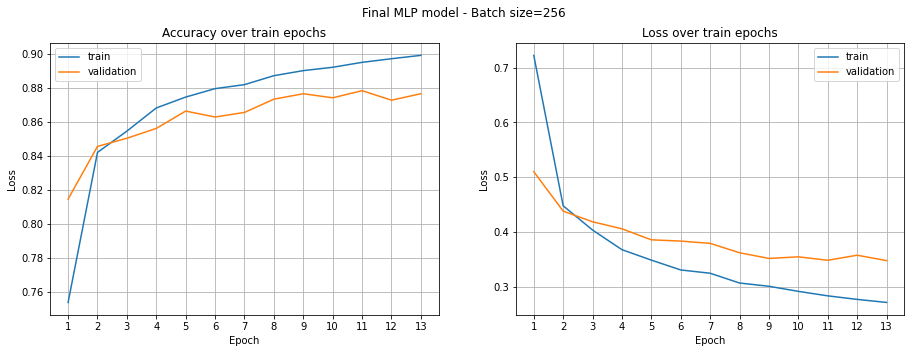

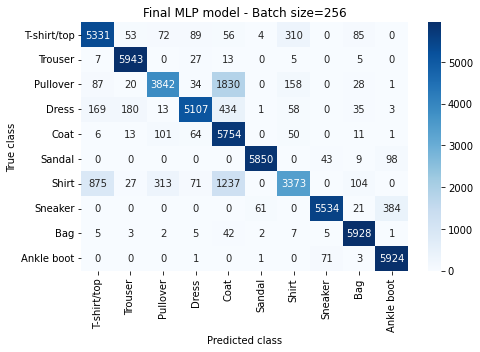

              precision    recall  f1-score   support

 T-shirt/top       0.79      0.88      0.84      1000
     Trouser       0.98      0.97      0.97      1000
    Pullover       0.77      0.82      0.80      1000
       Dress       0.85      0.91      0.88      1000
        Coat       0.80      0.79      0.80      1000
      Sandal       0.93      0.97      0.95      1000
       Shirt       0.76      0.61      0.68      1000
     Sneaker       0.92      0.96      0.94      1000
         Bag       0.98      0.94      0.96      1000
  Ankle boot       0.98      0.91      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [28]:
plot_model(mlp_final_fit_e13, epochs=13, loss=True,
    title="Final MLP model - Batch size=256", subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

plot_cm(mlp_final, title="Final MLP model - Batch size=256")

y_pred = mlp_final.predict(X_test)
print(classification_report(Y_test, np.argmax(y_pred, axis=1), labels=LABELS, target_names=LABELS_TEXT))

## Tests académicos
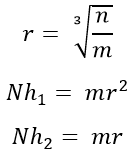
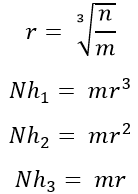
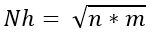

### Masters (1993)

Masters argumenta en su libro Practical Neural Network Recipes in C++ que no hay razones teóricas para utilizar más de dos capas ocultas en una red neuronal, como así tampoco razones prácticas. A su vez, propone utilizar la regla de la pirámide geométrica para determinar el número de neuronas ocultas, la cual establece que el número de neuronas para cada capa oculta formará una pirámide, donde el número de neuronas sigue disminuyendo de entrada a salida.

Para una red neuronal con una sola capa oculta, la cantidad de neuronas se calcula de la siguiente manera:



Donde:

- n es la cantidad de inputs
- m es la cantidad de outputs

Por otro lado, la cantidad de neuronas para una red con dos capas ocultas se calcula así:



Si se quisiera utilizar este mismo principio para una red con tres capas ocultas, a cantidad de neuronas en cada una de ellas se calcula de esta manera:

In [16]:
Nh = pow(INPUTS*OUTPUTS, 1/2)

mlp_masters_1l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_1l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh))
print()

mlp_masters_1l.summary()

Hidden neurons: 88

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 88)                69080     
                                                                 
 dense_1 (Dense)             (None, 10)                890       
                                                                 
Total params: 69,970
Trainable params: 69,970
Non-trainable params: 0
_________________________________________________________________


In [16]:
#r = (n/m)^(1/3)
r = pow(INPUTS/OUTPUTS, 1/3)    # = 4.279
                                
Nh1 = OUTPUTS*pow(r,2)          # = 183.179
Nh2 = OUTPUTS*r                 # = 42.799
                            
mlp_masters_2l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh1, activation='sigmoid'),
    Dense(Nh2, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_2l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:')
print('    - 1st Layer:', math.trunc(Nh1))
print('    - 2nd Layer:', math.trunc(Nh2))
print()

mlp_masters_2l.summary()

Hidden neurons:
    - 1st Layer: 183
    - 2nd Layer: 42

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 183)               143655    
                                                                 
 dense_1 (Dense)             (None, 42)                7728      
                                                                 
 dense_2 (Dense)             (None, 10)                430       
                                                                 
Total params: 151,813
Trainable params: 151,813
Non-trainable params: 0
__________________________________________________________

In [16]:
#r = (n/m)^(1/3)
r = pow(INPUTS/OUTPUTS, 1/3)    # = 4.279
                                
Nh1 = OUTPUTS*pow(r,3)          # = 783.478
Nh2 = OUTPUTS*pow(r,2)          # = 183.179
Nh3 = OUTPUTS*r                 # = 42.799
                            
mlp_masters_3l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh1, activation='sigmoid'),
    Dense(Nh2, activation='sigmoid'),
    Dense(Nh3, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_masters_3l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:')
print('    - 1st Layer:', math.trunc(Nh1))
print('    - 2nd Layer:', math.trunc(Nh2))
print('    - 3rd Layer:', math.trunc(Nh3))
print()

mlp_masters_3l.summary()

Hidden neurons:
    - 1st Layer: 784
    - 2nd Layer: 183
    - 3rd Layer: 42

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 183)               143655    
                                                                 
 dense_2 (Dense)             (None, 42)                7728      
                                                                 
 dense_3 (Dense)             (None, 10)                430       
                                           

In [17]:
mlp_masters_1l_fit = fit_model(mlp_masters_1l, batch_size=256, epochs=100, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.2471     0.8221     0.8460 | 2.2646     0.5039     0.4409 |
Validation | 0.3814     0.8124     0.8297 | 2.2113     0.5284     0.4740 |


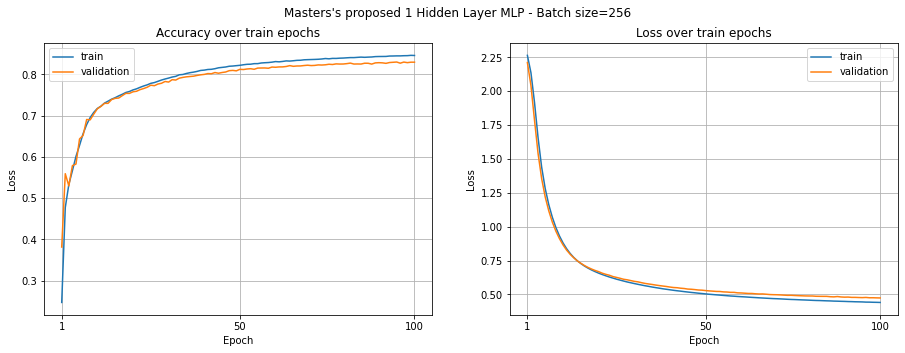

In [19]:
plot_model(mlp_masters_1l_fit, epochs=100, loss=True,
    title="Masters's proposed 1 Hidden Layer MLP - Batch size=256", subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_masters_2l_fit = fit_model(mlp_masters_2l, batch_size=256, epochs=100, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1387     0.8302     0.8537 | 2.2943     0.4731     0.4121 |
Validation | 0.2007     0.8196     0.8372 | 2.2582     0.5079     0.4553 |


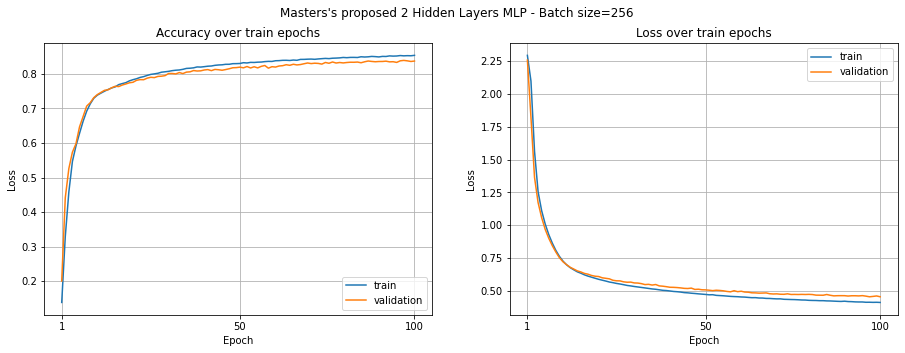

In [18]:
plot_model(mlp_masters_2l_fit, epochs=100, loss=True,
    title="Masters's proposed 2 Hidden Layers MLP - Batch size=256", subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_masters_3l_fit = fit_model(mlp_masters_3l, batch_size=256, epochs=100, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1021     0.8198     0.8415 | 2.3059     0.4953     0.4361 |
Validation | 0.1000     0.8117     0.8311 | 2.3018     0.5202     0.4707 |


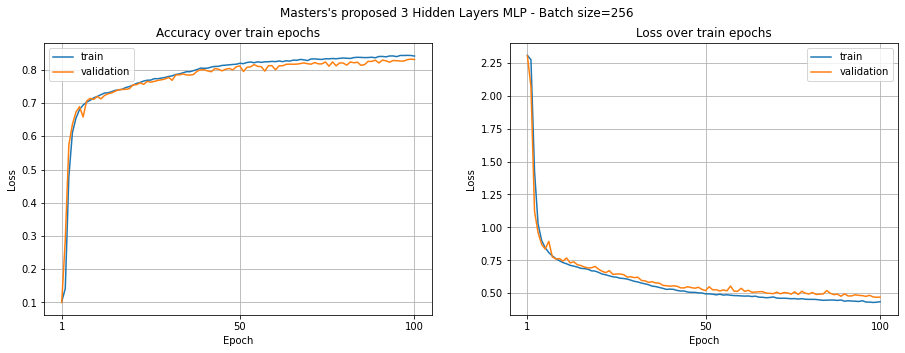

In [20]:
plot_model(mlp_masters_3l_fit, epochs=100, loss=True,
    title="Masters's proposed 3 Hidden Layers MLP - Batch size=256", subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

Al analizar mas métricas de estos tres modelos podemos ver que su comportamiento es muy similar, manteniendo todos los mismos niveles de Accuracy y Loss en ambos datasets, y sin claros indicativos de overfitting.
Un inconveniente de estos modelos es la cantidad de pesos que poseen debido al alto número de neuronas necesarias para las capas ocultas que establecen las ecuaciones planteadas por Masters. Los resultados arrojados por estos modelos son fácilmente alcanzables por redes MLP con una cantidad mucho más pequeña de pesos, como ya hemos visto en ejemplos anteriores.

### Tamura and Tateishi (1997)

Tamura and Tateishi desarrollaron un método basado en el Criterio de Información de Akaike. La cantidad de neuronas en una red neuronal tres capas es N-1, y en una red neuronal de cuatro capas, es (N/2)+3, donde N es resta entre la cantidad de inputs y outputs.

Tamura and Tateishi developed a method to fix the number of hidden neuron. The number of hidden neurons in three layer neural network is N − 1 and four-layer neural network is N/2 + 3 where N is the input-target relation.

In [16]:
N = INPUTS-OUTPUTS              # 774
Nh = N-1                        # 773

mlp_tamura_3l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_tamura_3l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh), 'on each of the 3 layers')
print()

mlp_tamura_3l.summary()

Hidden neurons: 773 on each of the 3 layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 773)               606805    
                                                                 
 dense_1 (Dense)             (None, 773)               598302    
                                                                 
 dense_2 (Dense)             (None, 773)               598302    
                                                                 
 dense_3 (Dense)             (None, 10)                7740      
                                                                 
Total param

In [16]:
N = INPUTS-OUTPUTS              # 774
Nh = (N/2)+3                    # 390

mlp_tamura_4l = Sequential([
    Rescaling(1/255, input_shape=(28,28,1)),
    Flatten(),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(Nh, activation='sigmoid'),
    Dense(len(LABELS), activation='softmax'),
])

mlp_tamura_4l.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

print('Hidden neurons:', math.trunc(Nh), 'on each of the 4 layers')
print()

mlp_tamura_4l.summary()

Hidden neurons: 390 on each of the 4 layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 390)               306150    
                                                                 
 dense_1 (Dense)             (None, 390)               152490    
                                                                 
 dense_2 (Dense)             (None, 390)               152490    
                                                                 
 dense_3 (Dense)             (None, 390)               152490    
                                                                 
 dense_4 (D

In [17]:
mlp_tamura_3l_fit = fit_model(mlp_tamura_3l, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1022     0.7755     0.7937 | 2.3252     0.6073     0.5533 |
Validation | 0.1000     0.7704     0.7844 | 2.3117     0.6382     0.5828 |


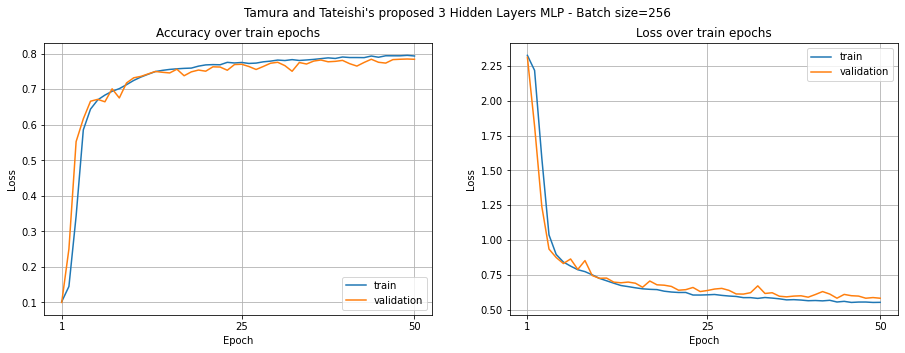

In [18]:
plot_model(mlp_tamura_3l_fit, epochs=50, loss=True,
    title="Tamura and Tateishi's proposed 3 Hidden Layers MLP - Batch size=256", subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [17]:
mlp_tamura_4l_fit = fit_model(mlp_tamura_4l, batch_size=256, epochs=50, compare=True)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.1005     0.7376     0.7564 | 2.3177     0.6866     0.6458 |
Validation | 0.1000     0.7380     0.7513 | 2.3061     0.7045     0.6573 |


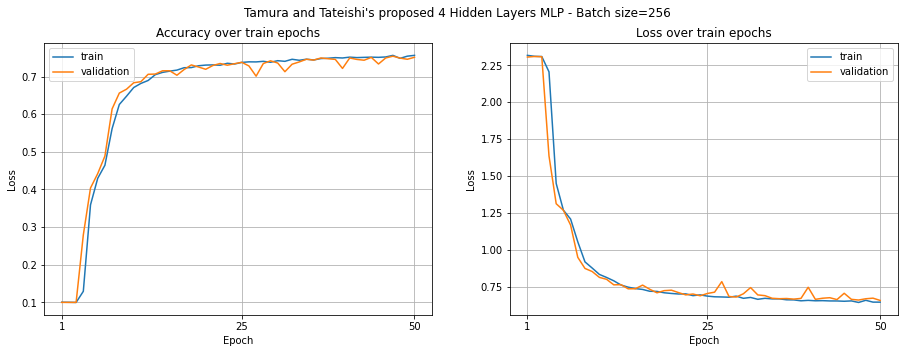

In [18]:
plot_model(mlp_tamura_4l_fit, epochs=50, loss=True,
    title="Tamura and Tateishi's proposed 4 Hidden Layers MLP - Batch size=256", subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

Al igual que en el caso de las redes MLP basadas en la propuesta de Masters, la cantidad de pesos en los modelos de Tamura y Tateishi son muy elevados, y sus resultados son fácilmente alcanzables por redes MLP con una cantidad mucho más pequeña de neuronas, como ya hemos visto en ejemplos anteriores.

# CNN Experimentation

Para experimentar con diversos aspectos de redes neuronales convolucionales vamos a buscar variar no solo su arquitectura -en términos de cantidad de capas ocultas y neuronas- sino también con la cantidad de filtros, tamaño del kernel, stride y MaxPooling utilizados.

## Filtros
Planteamos tres modelos:
1. `cnn_filters_test_1`: CNN con una capa convolucional con 1 filtro.
2. `cnn_filters_test_8`: CNN con una capa convolucional con 8 filtros.
3. `cnn_filters_test_32`: CNN con una capa convolucional con 32 filtros.

In [ ]:
cnn_filters_test_1 = Sequential([
    Convolution2D(filters=1, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_filters_test_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_filters_test_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 25, 25, 1)         17        
                                                                 
 flatten (Flatten)           (None, 625)               0         
                                                                 
 dense (Dense)               (None, 10)                6260      
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 6,387
Trainable params: 6,387
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_filters_test_8 = Sequential([
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_filters_test_8.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_filters_test_8.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 25, 25, 8)         136       
                                                                 
 flatten_1 (Flatten)         (None, 5000)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                50010     
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
Total params: 50,256
Trainable params: 50,256
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_filters_test_32 = Sequential([
    Convolution2D(filters=32, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_filters_test_32.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_filters_test_32.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        544       
                                                                 
 flatten_2 (Flatten)         (None, 20000)             0         
                                                                 
 dense_4 (Dense)             (None, 10)                200010    
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
Total params: 200,664
Trainable params: 200,664
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_filters_test_1_fit = fit_model(cnn_filters_test_1, epochs=50, batch_size=256)

2022-05-29 21:46:47.139926: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-29 21:46:48.279417: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.6354     0.8587     0.8673 | 1.0761     0.4043     0.3762 |
Validation | 0.7569     0.8433     0.8395 | 0.6621     0.4452     0.4496 |


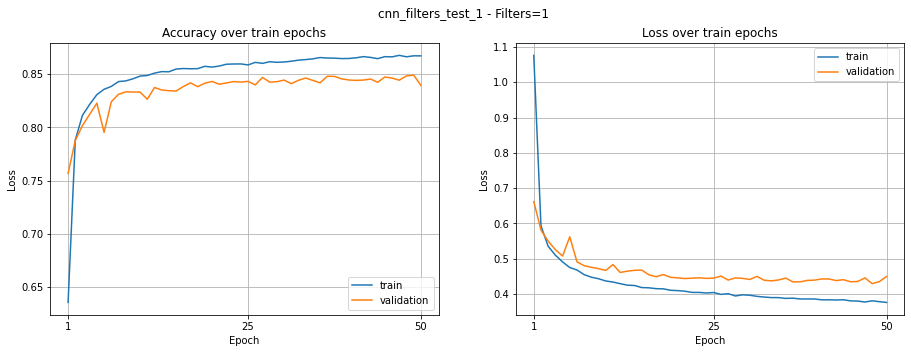

In [ ]:
plot_model(cnn_filters_test_1_fit, epochs=50, loss=True,
    title='cnn_filters_test_1 - Filters=1', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_filters_test_8_fit = fit_model(cnn_filters_test_8, epochs=50, batch_size=256)

2022-05-30 09:24:26.332803: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-30 09:24:27.516051: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.5861     0.9086     0.9307 | 1.1682     0.2552     0.1937 |
Validation | 0.7378     0.8884     0.8875 | 0.7817     0.3271     0.3430 |


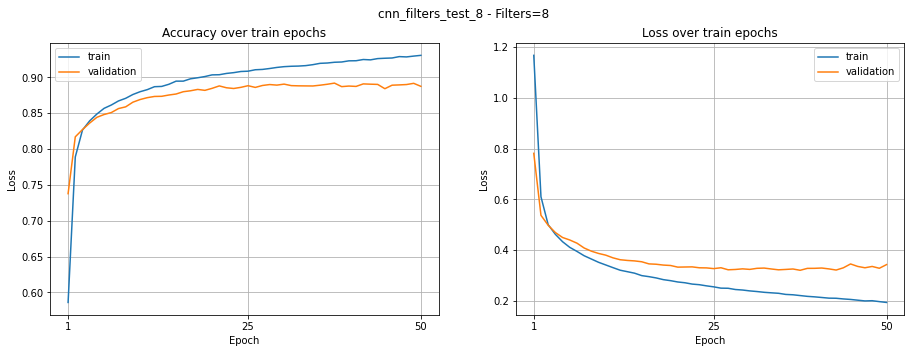

In [ ]:
plot_model(cnn_filters_test_8_fit, epochs=50, loss=True,
    title='cnn_filters_test_8 - Filters=8', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_filters_test_8_fit = fit_model(cnn_filters_test_8, epochs=50, batch_size=256)

2022-05-29 20:14:30.226198: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-29 20:14:31.365505: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.5727     0.9290     0.9586 | 1.1478     0.1986     0.1198 |
Validation | 0.7887     0.8899     0.8910 | 0.6324     0.3210     0.3704 |


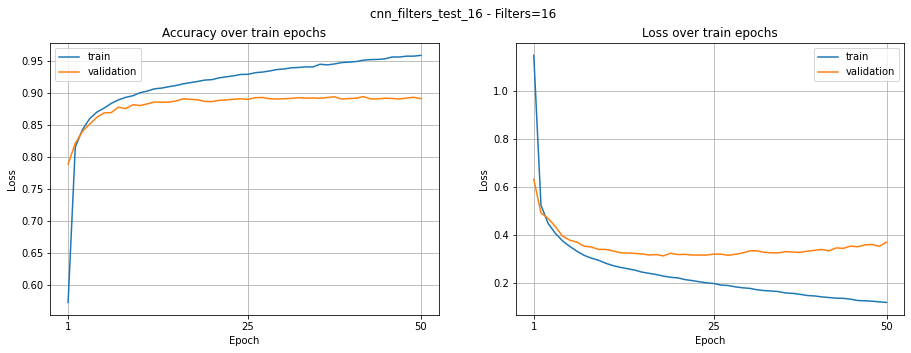

In [ ]:
plot_model(cnn_filters_test_8_fit, epochs=50, loss=True,
    title='cnn_filters_test_8 - Filters=8', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_filters_test_32_fit = fit_model(cnn_filters_test_32, epochs=50, batch_size=256)

2022-05-29 20:16:21.533525: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-05-29 20:16:23.094144: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.6723     0.9391     0.9740 | 0.9258     0.1687     0.0781 |
Validation | 0.8075     0.8975     0.8995 | 0.5567     0.3081     0.3907 |


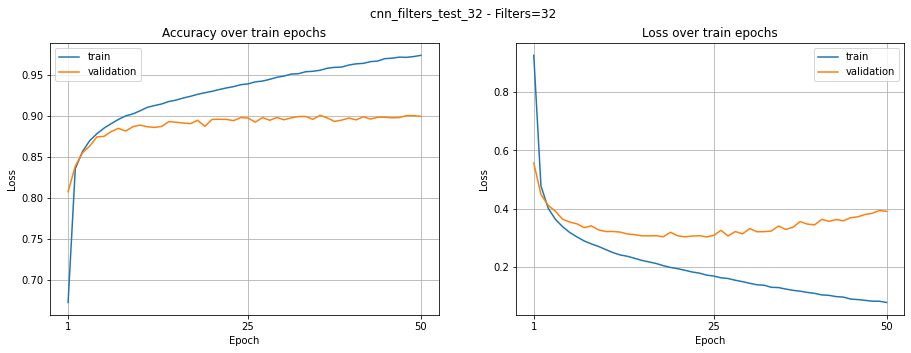

In [ ]:
plot_model(cnn_filters_test_32_fit, epochs=50, loss=True,
    title='cnn_filters_test_32 - Filters=32', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

Las métricas observadas en estos modelos nos indican que aumentar la cantidad de filtros aumenta el Accuracy y disminuye el Loss del modelo. Esto ocurre ya que la cantidad de filtros -o kernels- que se crean son entrenados para detectar determinada feature en el input. A mayor cantidad de filtros, mas filtros serán entrenados para detectar diferentes tipos de features en la imagen.

## Tamaño del kernel

Planteamos cuatro modelos similares utilizando diferentes `kernel_size` en sus capas convolucionales para analizar su comportamiento:
1. `cnn_kernel_test_1`: `kernel_size`=(1,1)
2. `cnn_kernel_test_3`: `kernel_size`=(3,3)
3. `cnn_kernel_test_5`: `kernel_size`=(5,5)
4. `cnn_kernel_test_7`: `kernel_size`=(7,7)

In [ ]:
cnn_kernel_test_1 = Sequential([
    Convolution2D(filters=8, kernel_size=(1, 1), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(1, 1), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(1, 1), strides=1, padding='same', activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_kernel_test_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_kernel_test_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 8)         16        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 8)         72        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 8)           72        
_________________________________________________________________
flatten_3 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [ ]:
cnn_kernel_test_3 = Sequential([
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(3, 3), strides=1, padding='same', activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_kernel_test_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_kernel_test_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_3 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [ ]:
cnn_kernel_test_5 = Sequential([
    Convolution2D(filters=8, kernel_size=(5, 5), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(5, 5), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(5, 5), strides=1, padding='same', activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_kernel_test_5.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_kernel_test_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1608      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 8)           1608      
_________________________________________________________________
flatten_4 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [ ]:
cnn_kernel_test_7 = Sequential([
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(7, 7), strides=1, padding='same', activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_kernel_test_7.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_kernel_test_7.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 8)         400       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 8)         3144      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 8)           3144      
_________________________________________________________________
flatten_5 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [ ]:
cnn_kernel_test_1_fit = fit_model(cnn_kernel_test_1, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.3325     0.8237     0.8300 | 1.8850     0.4868     0.4666 |
Validation | 0.5058     0.8179     0.8157 | 1.3887     0.5077     0.5082 |


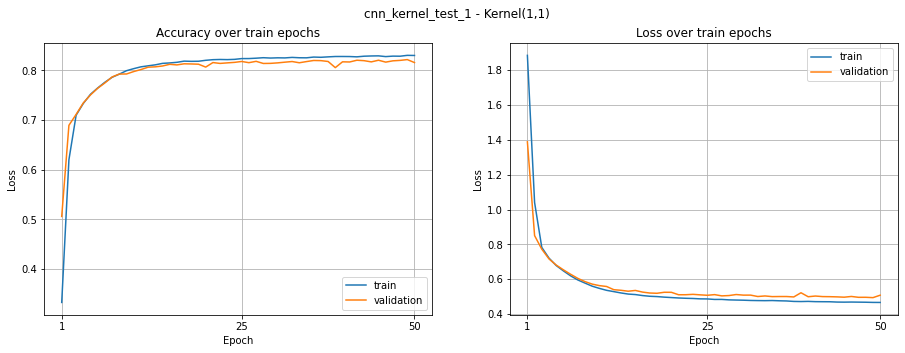

In [ ]:
plot_model(cnn_kernel_test_1_fit, epochs=50, loss=True,
    title='cnn_kernel_test_1 - Kernel(1,1)', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_kernel_test_3_fit = fit_model(cnn_kernel_test_3, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.4450     0.8823     0.8983 | 1.5718     0.3337     0.2880 |
Validation | 0.6678     0.8736     0.8821 | 0.9423     0.3569     0.3343 |


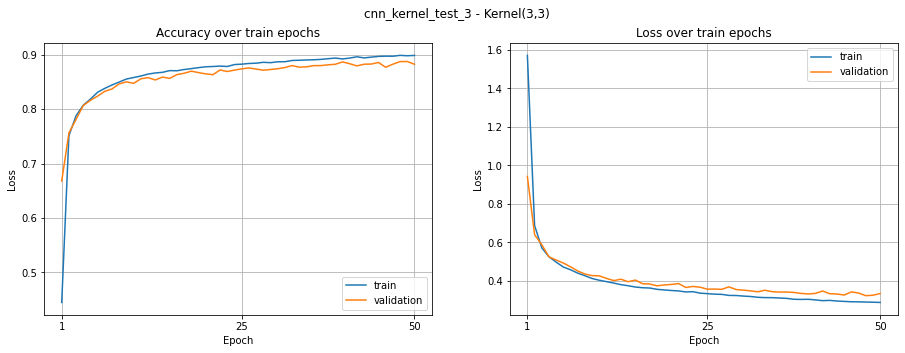

In [ ]:
plot_model(cnn_kernel_test_3_fit, epochs=50, loss=True,
    title='cnn_kernel_test_3 - Kernel(3,3)', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_kernel_test_5_fit = fit_model(cnn_kernel_test_5, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.5251     0.8946     0.9093 | 1.3054     0.2987     0.2519 |
Validation | 0.7217     0.8811     0.8878 | 0.7853     0.3409     0.3192 |


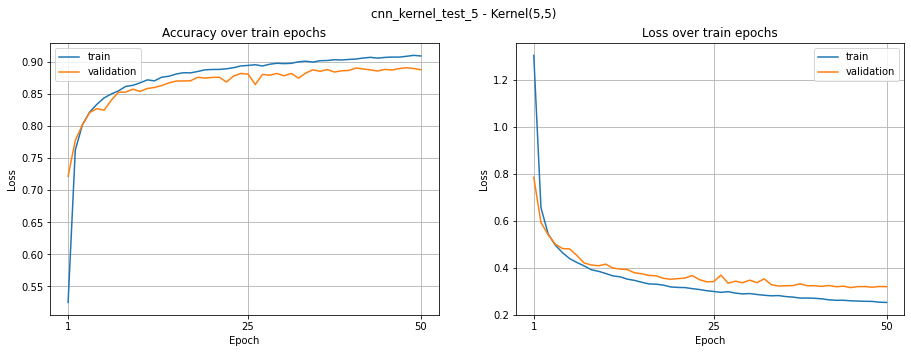

In [ ]:
plot_model(cnn_kernel_test_5_fit, epochs=50, loss=True,
    title='cnn_kernel_test_5 - Kernel(5,5)', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_kernel_test_7_fit = fit_model(cnn_kernel_test_7, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.4751     0.8996     0.9156 | 1.5659     0.2828     0.2289 |
Validation | 0.6333     0.8830     0.8918 | 1.0931     0.3345     0.3191 |


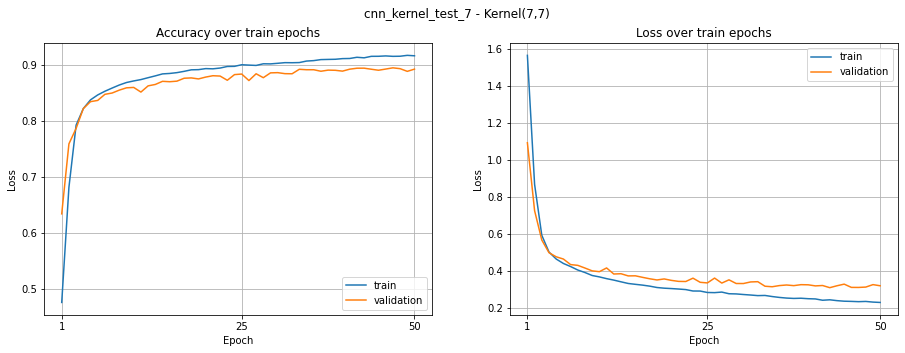

In [ ]:
plot_model(cnn_kernel_test_7_fit, epochs=50, loss=True,
    title='cnn_kernel_test_7 - Kernel(7,7)', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

En nuestro caso el kernel de dimensiones (1,1) obtiene las métricas más bajas, mientras que los resultados de los demás ejemplos mantienen un Accuracy de Validation muy similar que tiende a subir muy levemente a medida que utilizamos valores más grandes, a diferencia del Loss de Validation que inicia en 0.5 y luego baja rápidamente al rango de 0.33-0.31.

Podemos concluir que a medida de que el valor del `kernel_size` aumenta obtenemos mejores métricas en general (mayor Accuracy y menor Loss), ya que un kernel de mayores dimensiones aprende features más grandes y por lo tanto complejas. Debe tenerse en cuenta que el uso de un Kernel más también implica una mayor cantidad de pesos en la red, lo cual implica un tiempo de entrenamiento mayor.

## Stride
Planteamos tres modelos de similares características variando solamente el valor del `stride` de sus capas convolucionales.
1. `cnn_stride_test_1`: `stride`=1
2. `cnn_stride_test_2`: `stride`=2
3. `cnn_stride_test_3`: `stride`=3

In [ ]:
cnn_stride_test_1 = Sequential([
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_stride_test_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_stride_test_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 25, 25, 8)         136       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 8)           1032      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 1, 8)           1032      
_________________________________________________________________
flatten_3 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [ ]:
cnn_stride_test_2 = Sequential([
    Convolution2D(filters=8, kernel_size=(4, 4), strides=2, padding="same", activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=2, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=2, padding="same", activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_stride_test_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_stride_test_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 8)         136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 8)           1032      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 8)           1032      
_________________________________________________________________
flatten_4 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)               

In [ ]:
cnn_stride_test_3 = Sequential([
    Convolution2D(filters=8, kernel_size=(4, 4), strides=3, padding="same", activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=3, padding="same", activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=3, padding="same", activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_stride_test_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_stride_test_3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 10, 10, 8)         136       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 8)           0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 2, 8)           1032      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 8)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 8)           1032      
_________________________________________________________________
flatten_5 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [ ]:
cnn_stride_test_1_fit = fit_model(cnn_stride_test_1, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.3367     0.8482     0.8683 | 1.8989     0.4228     0.3703 |
Validation | 0.5468     0.8415     0.8561 | 1.3214     0.4509     0.4083 |


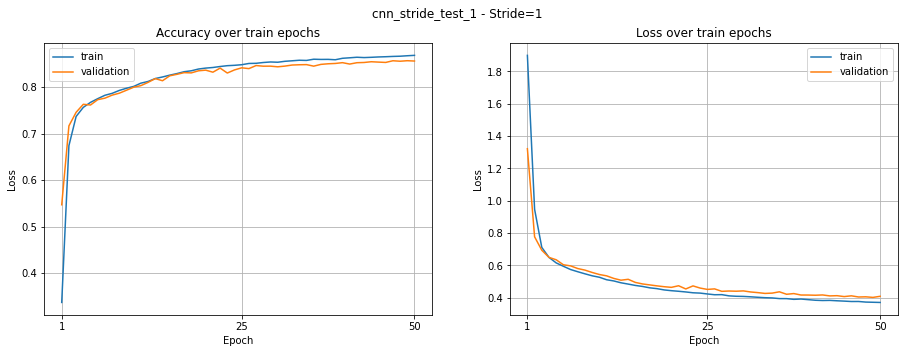

In [ ]:
plot_model(cnn_stride_test_1_fit, epochs=50, loss=True,
    title='cnn_stride_test_1 - Stride=1', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_stride_test_2_fit = fit_model(cnn_stride_test_2, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.2481     0.8269     0.8501 | 1.9592     0.4853     0.4221 |
Validation | 0.3515     0.8188     0.8400 | 1.5938     0.5143     0.4584 |


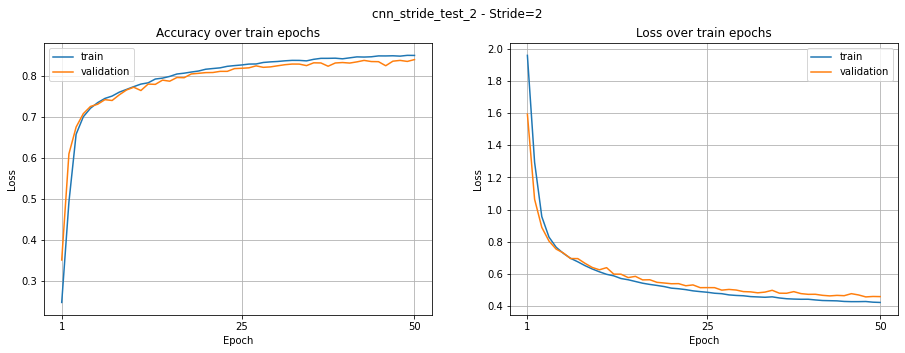

In [ ]:
plot_model(cnn_stride_test_2_fit, epochs=50, loss=True,
    title='cnn_stride_test_2 - Stride=2', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_stride_test_3_fit = fit_model(cnn_stride_test_3, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.3251     0.8443     0.8629 | 1.8903     0.4364     0.3765 |
Validation | 0.5814     0.8378     0.8499 | 1.1868     0.4623     0.4173 |


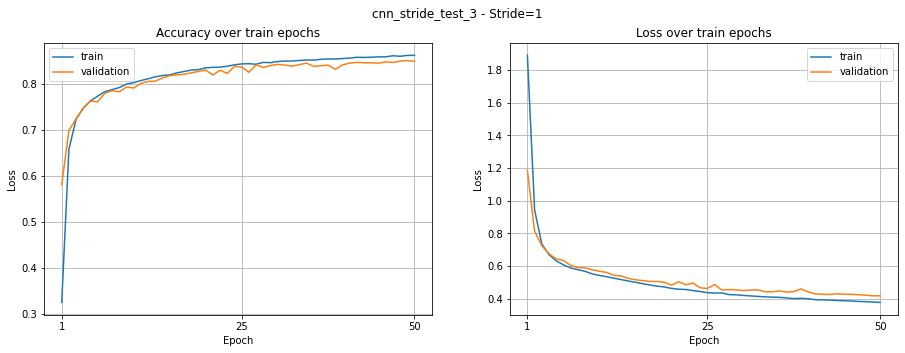

In [ ]:
plot_model(cnn_stride_test_3_fit, epochs=50, loss=True,
    title='cnn_stride_test_3 - Stride=3', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

El comportamiento de estas redes varía muy poco entre los ejemplos ejecutados, lo cual dificulta llegar a una conclusión concreta. Esto nos lleva a estimar que, al menos en este caso particular, con este diseño de red y con los datos actuales, agrandar el valor del `stride` no se traduce en un cambio substancial en el resultado del modelo.

## MaxPooling

Planteamos dos modelos de similares características, donde uno de ellos utiliza MaxPooling(2,2) entre sus capas convolucionales y el otro no.
1. `cnn_maxpooling_test_1`: Sin MaxPooling
2. `cnn_maxpooling_test_1`: Tres capas de MaxPooling(2,2)

In [ ]:
cnn_maxpooling_test_1 = Sequential([
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(28, 28, 1)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1, activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_maxpooling_test_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_maxpooling_test_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 25, 25, 8)         136       
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 8)         1032      
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 19, 8)         1032      
                                                                 
 flatten_3 (Flatten)         (None, 2888)              0         
                                                                 
 dense_6 (Dense)             (None, 10)                28890     
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
Total params: 31,200
Trainable params: 31,200
Non-trai

In [ ]:
cnn_maxpooling_test_2 = Sequential([
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1,padding = 'same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1,padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1,padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_maxpooling_test_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_maxpooling_test_2.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 8)         136       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         1032      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 8)           1032      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 8)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 72)               

In [ ]:
cnn_maxpooling_test_1_fit = fit_model(cnn_maxpooling_test_1, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.6199     0.9111     0.9322 | 1.1385     0.2469     0.1822 |
Validation | 0.7649     0.8954     0.9029 | 0.6832     0.2929     0.2842 |


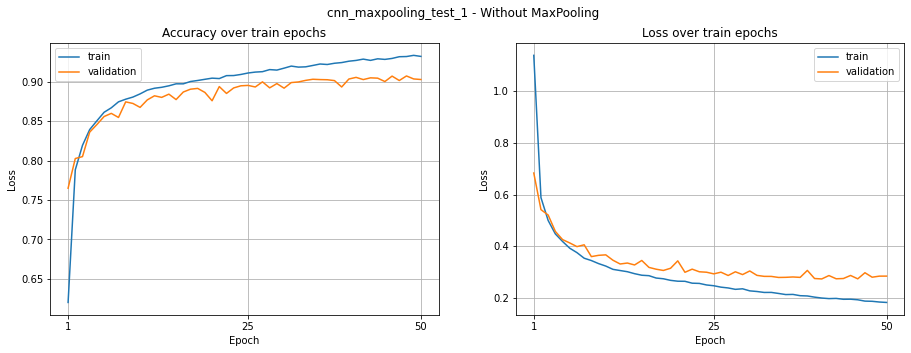

In [ ]:
plot_model(cnn_maxpooling_test_1_fit, epochs=50, loss=True,
    title='cnn_maxpooling_test_1 - Without MaxPooling', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

In [ ]:
cnn_maxpooling_test_2_fit = fit_model(cnn_maxpooling_test_2, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.3334     0.8626     0.8847 | 1.8271     0.3832     0.3184 |
Validation | 0.5928     0.8537     0.8648 | 1.0615     0.4120     0.3785 |


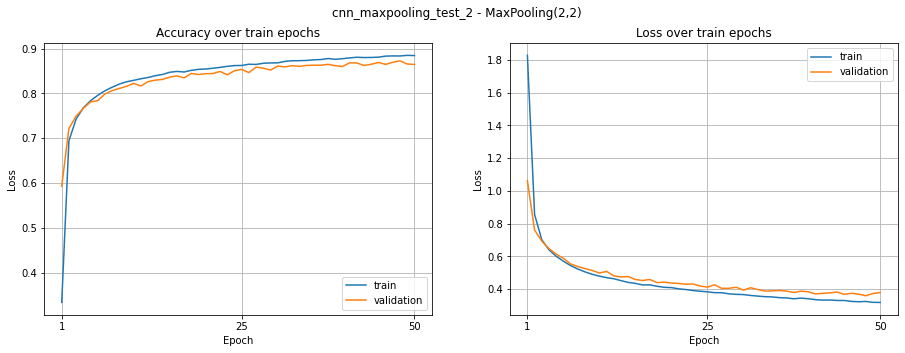

In [ ]:
plot_model(cnn_maxpooling_test_2_fit, epochs=50, loss=True,
    title='cnn_maxpooling_test_2 - MaxPooling(2,2)', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

En el summary de los modelos podemos ver como el 1ero tiene 31200 pesos, mientras que el segundo tiene tan solo 3040, gracias al downsampling que realiza MaxPooling. Y si bien la reducción de pesos es del orden del 90%, el Accuracy de Validation del segundo modelo bajó solo 4 puntos porcentuales al final del entrenamiento, mientras que el Loss aumentó casi 10 puntos comparado a la versión previa.

Podemos discutir que en un principio implementamos demasiadas capas de MaxPooling ya que terminamos con un output de 3x3, por lo que a continuación realizamos otro ejemplo (`cnn_maxpooling_test_3`) quitando la última capa.

In [ ]:
cnn_maxpooling_test_3 = Sequential([
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1,padding = 'same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1,padding = 'same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Convolution2D(filters=8, kernel_size=(4, 4), strides=1,padding = 'same', activation='relu'),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(OUTPUTS, activation='softmax'),
])

cnn_maxpooling_test_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy',],
)

cnn_maxpooling_test_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 8)         136       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 8)         1032      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 8)           1032      
_________________________________________________________________
flatten_3 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [ ]:
cnn_maxpooling_test_3_fit = fit_model(cnn_maxpooling_test_3, epochs=50, batch_size=512)

           |           Accuracy           |             Loss             |
           | Initial    Middle      Final | Initial    Middle      Final |
     Train | 0.4097     0.8841     0.9011 | 1.6253     0.3309     0.2783 |
Validation | 0.6554     0.8674     0.8889 | 0.9706     0.3754     0.3228 |


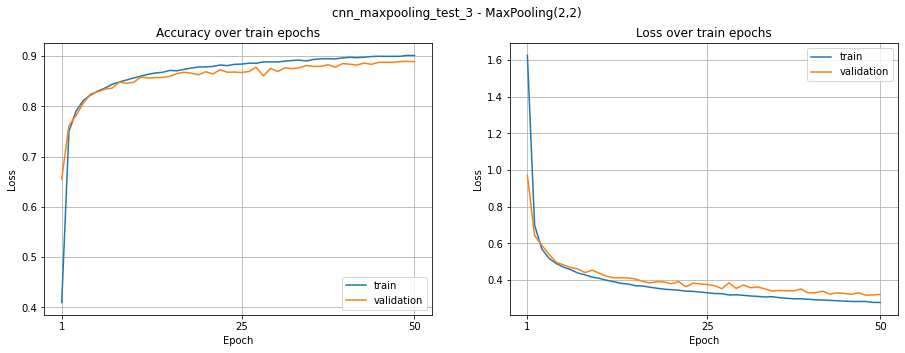

In [ ]:
plot_model(cnn_maxpooling_test_3_fit, epochs=50, loss=True,
    title='cnn_maxpooling_test_3 - MaxPooling(2,2)', subtitle_1='Accuracy over train epochs', subtitle_2='Loss over train epochs')

Con este útlimo ejemplo, retirando la última capa de MaxPooling, entregando así a las capas densas un output de 7x7x8 (en lugar de 3x3x8), obtenemos métricas que llegan a un punto medio entre los ejemplos 1 y 2 anteriores, perdiendo solo 2 puntos de Accuracy y sumando 4 puntos de Loss con respecto al modelo sin MaxPooling. Además, la tendencia de los gráficos indica que podría seguir aprendiendo en los próximos Epochs y llegar a valores similares.

# Prunning

https://www.tensorflow.org/model_optimization/guide/pruning/pruning_with_keras

In [ ]:
import tempfile
import os

import tensorflow as tf
import numpy as np

from tensorflow import keras

%load_ext tensorboard

### Entrenar un modelo sin podar

In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(
  train_images,
  train_labels,
  epochs=4,
  validation_split=0.1,
)

In [ ]:
_, baseline_model_accuracy = model.evaluate(
    test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)

### Ajuste el modelo preentrenado con poda

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = train_images.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

In [ ]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(train_images, train_labels,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

In [ ]:
_, model_for_pruning_accuracy = model_for_pruning.evaluate(
   test_images, test_labels, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy) 
print('Pruned test accuracy:', model_for_pruning_accuracy)

# Data Augmentation

In [ ]:
train, test = fashion_mnist.load_data()
X_train, Y_train = train 
X_test, Y_test = test

In [ ]:
train_alterado = ImageDataGenerator(
    rescale=1/255,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    vertical_flip=False,
    
)
train_DA = train_alterado.flow(X_train.reshape(60000,28,28,1),Y_train,batch_size=60000)

X_train_DA, Y_train_DA = train_DA.next()
X_train_DA.shape

In [ ]:
sample_images(train_DA)

In [ ]:
X_train=X_train.reshape(60000,28,28,1)

In [ ]:
#realizamos la concatenación de los datasets original y el modificado
X_train_DA = np.concatenate((X_train_DA, X_train))
Y_train_DA = np.concatenate((Y_train_DA, Y_train))
print(X_train.shape)
print(X_train_DA.shape)